In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from  sklearn.ensemble import IsolationForest

from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import GridSearchCV

import optuna
# Устанавливаем уровень логирования для optuna на WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING) # INFO, WARNING, CRITICAL, ERROR

from clustergram import Clustergram

from functools import partial # чтобы вызывать функции с доп параметрами

pd.set_option('display.float_format', None)
#pd.set_option('display.float_format', '{:.6f}'.format)

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

<img src='projectpics/proj4pic0.png' width='70%' style='display:block; margin:auto;'>

<h2 id='contents'>Оглавляшка:</h2>

0. [Блок функций](#funcblock) 

<center><span style="font-size:25px;">Часть 1. Знакомство с данными, обработка пропусков и выбросов.</span></center>

* [Знакомство с данными](#intro)
* [Задание 1.1](#ex_1_1) выявление пропусков
* [Задание 1.2](#ex_1_2) определение слова, которым были закодированы пропуски
* [Задание 1.3](#ex_1_3) преобразование признака `balance` в `float`
* [Задание 1.4](#ex_1_4) замена пропусков признака `balance`
* [Задание 1.5](#ex_1_5) замена пропусков признака `job` и `education`
* [Задание 1.6](#ex_1_6) определение границ выбросо признака `balance` по методу Тьюки
* [Задание 1.7](#ex_1_7) вывод размерности таблицы, после удаления выбросов и присваивание `новой` переменной + бонус график

<center><span style="font-size:25px;">Часть 2: Разведывательный анализ. (EDA)</span></center>

* [Начальные некоторые преобразования второй части](#sometransformationchapter2) трансформация yes-no в бинарные столбцы
* [Задание 2.1](#ex_2_1) распределение целевого признака `deposit`
* [Бонус второй части. Визуализация числовых признаков.](#bonus_2_numeric) Графики
* [Задание 2.2](#ex_2_2) про признак `age`
* [Задание 2.3](#ex_2_3) визуализация признака `dutration`
* [Бонус второй части. Визуализация категориальных признаков.](#bonus_2_category)
* [Задание 2.4](#ex_2_4) визуализация признака `month`
* [Задание 2.5](#ex_2_5) визуализация признака `job`
* [Задание 2.6](#ex_2_6) про признак `poutcome`
* [Задание 2.7](#ex_2_7) снова про признак `month`
* [Задание 2.8](#ex_2_8) здесь происходит категоризирование признака `age` (добавляется новый столбец)
* [Задание 2.9](#ex_2_9) визуализация признаков `marital`, `education`, `job`
* [Задание 2.10](#ex_2_10) про соотношение `marital` и `deposit`
* [Задание 2.11](#ex_2_11) про тепловые карты `marital` и `education`
* [Ещё 1 последний бонус](#final_bonus) Кластерограмма `Clustergram`

<center><span style="font-size:25px;">Часть 3: Отбор и преобразование признаков.</span></center>

* [Начальные преобразования третьей части](#sometransformationchapter3) кодирование категориальных переменных
* [Задание 3.1, 3.2, 3.3](#ex_3_1) однострочные вопросики
* [Задание 3.4](#ex_3_4) `dummy`-кодирование переменных `'job', 'marital', 'contact', 'month', 'poutcome'`
* [Задание 3.5 + 3.6](#ex_3_5) Корреляция
* [Задание 3.7 + 3.8](#ex_3_7) Валидация (Здесь X и y)
* [Задание 3.9](#ex_3_9) Отбор признаков через `SelectKBest(f_classif)` и новые X_train, X_test
* [Задание 3.10](#ex_3_10) Нормализация `MinMax`

<center><span style="font-size:25px;">Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья.</span></center>

* [Задание 4.1](#ex_4_1) обучение простой логистической регрессии
* [Задание 4.2](#ex_4_2) обучение `DecisionTreeClassifier`
* [Задание 4.3, 4.4](#ex_4_3) перебор `max_depth` для определения лучшего `accuracy`
* [Задание 4.5](#ex_4_5) Использование `GridSearchCV`

<center><span style="font-size:25px;">Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза.</span></center>

* [Задание 5.1](#ex_5_1) обучение модели `RandomForestClassifier`
* [Задание 5.2, 5.3](#ex_5_2) градиентный бустинг `GradientBoostingClassifier`
* [Задание 5.4](#ex_5_4) стейк-инг (xD) `StackingClassifier`
* [Задание 5.5](#ex_5_5) про `feature_importances_`
* [Задание 5.6](#ex_5_6) использование `Optuna` + модифицированная функция под случайный лес

---

## Блок функций <a id='funcblock'></a>

In [2]:
# My info.
def my_info(df, catmaxnum=None):
    """Info function to show basic df indicators

    Args:
        df (pd.Dataframe): any df.
        catmaxnum (int): the minimum threshold(rus: порог) after which a column will be considered a category. Defaults to None.

    Returns:
        _type_: HTML object
    """
    import pandas as pd
    import numpy as np
    from IPython.display import HTML
    
    df_copy = df.copy() # it needs here.
    
    # Loop and condition for moment, when there are unhashable types in our column. (list, dict, set)
    for i in df_copy.columns:
        if any(isinstance(cell, (list, set, dict)) for cell in df_copy[i]):
            df_copy[i] = df_copy[i].astype(str)
                
    func_df = pd.DataFrame({
        
        'column': df_copy.columns,
        'num of unique vals': df_copy.nunique(),
        'type': [str(df_copy.dtypes[i]) for i in df_copy.columns],
        'mode': [round(df_copy[i].mode()[0], 2) if np.issubdtype(df_copy[i].dtype, np.number) else df_copy[i].mode()[0] for i in df_copy.columns],
        'number of entries': len(df_copy),
        'NaN vals': df_copy.isna().sum(),
        'number of dublics': df_copy.duplicated().sum(),
        'describe': [f"{df_copy[i].describe().reindex(['min', 'max', 'mean', 'std']).round(2).to_string()}" if np.issubdtype(df_copy[i].dtype, np.number) else 'type obj' for i in df_copy.columns]
        
    }).sort_values(by=['num of unique vals', 'column'], ascending=[True, True]).reset_index(drop=True)
    
    if catmaxnum:
        func_df.insert(3, 'classification', ['category' if i < catmaxnum else 'numeric' for i in func_df['num of unique vals']])
    
    if len(str(df_copy.memory_usage(deep=True).sum())) > 6:
        print(f"memory usage: {str(round(df_copy.memory_usage(deep=True).sum() / 1e6, 1)) + ' MB'}")
    else:
        print(f"memory usage: {str(round(df_copy.memory_usage(deep=True).sum() / 1e3, 1)) + ' KB'}")
    
    # Add CSS style to left-align the "describe" column
    html_output = func_df.to_html().replace('\\n', '<br>')
    html_output = html_output.replace('<td>min', '<td style="text-align: left;">min...:')
    html_output = html_output.replace('<br>max', '<br style="text-align: left;">max..:')
    html_output = html_output.replace('<br>mean', '<br style="text-align: left;">mean:')
    html_output = html_output.replace('<br>std', '<br style="text-align: left;">std....:')
    
    return HTML(html_output)

#######################################

def my_corr(df, targ_col=False, method='pearson', corrneg=0, corrpos=0, figsize=(10, 5), xtickrot=90, annot_kws={'size': 'medium'}, show_high_corr_cols_names=False):
    """
    The function of drawing a correlation graph, but not an ordinary one, but one in which the lower part is the entire one,
    and the upper part contains only those correlation values that are greater and less than some number we have specified.

    Args:
        df (pd.Dataframe): any df.
        method (str): method u like. default pearson.
        corrneg (float): negative threshold for display. (for negative correlation value)
        corrpos (float): positive threshold. (for a positive value) both default to 0. At 0, the full standard correlation matrix will be displayed.
        figsize (tuple): u know what it is.)
        xtickrot(int): rotate x axis labels. default 90
        annot_kws(dict): size of annot font. default {"size": 'medium'}
        show_high_corr_cols_names(bool): if we wanna watch names of high corr cols. default False

    Returns:
        _type_: plt or df
    """
    
    import pandas as pd
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if targ_col:
        corr_df = pd.concat([df.drop(targ_col, axis=1), df[targ_col]], axis=1).corr(numeric_only=True, method=method).copy()
    else:
        corr_df = df.corr(numeric_only=True, method=method).copy()
    
    # We find indices where the correlation value is greater and less than a certain number.
    high_corr_pairs = ((corr_df >= corrpos) & (corr_df <= 1)) | (corr_df <= corrneg)
    
    # We receive only those pairs of features where the condition is met. The rest are NaN.
    high_corr_features = corr_df[high_corr_pairs]
    
    # if we wanna watch high corr pairs in the form of a df. Without picture. I decided 2 split it up.
    if show_high_corr_cols_names:
        # stack hight corr feature.
        shccn = high_corr_features.stack().to_frame().reset_index().rename(columns={0: 'corr'})
        # sort'em.
        shccn[['level_0', 'level_1']] = np.sort(shccn[['level_0', 'level_1']], axis=1)
        # keep only 1 pair of high corr cols names.
        shccn = shccn.groupby(['level_0', 'level_1']).first().reset_index()
        # removing the diagonal.
        shccn = shccn.query('level_0 != level_1')
        # return with resetting index.
        return shccn.sort_values(by='corr', ascending=False).reset_index(drop=True)
    
    # if we wanna see the pic.
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
        plt.suptitle(f'Correlation of incoming dataframe features.')
        
        # 2 masks, one triu (tri upper), the second tril (tri lower).
        mask_for_logging_df = np.triu(np.ones_like(corr_df, dtype=bool))
        mask_for_logging_df_2 = np.tril(np.ones_like(high_corr_features, dtype=bool))
        
        # 2 graphics. I didn’t figure out how to make such a picture using 1 chart. That's why cbar=False helps.
        sns.heatmap(corr_df, annot=True, annot_kws=annot_kws, cmap='coolwarm', mask=mask_for_logging_df, vmax=1, vmin=-1, linewidths=0.1, fmt='.2f') # <--- lower part
        
        # if condition == 1 high_corr_features contains only nan, so we dont need upper part. 
        # or.. high_corr_features has no nan, i.e. corrpos and corrneg == 0, so we draw all corr matrix.
        if (len(high_corr_features.isna().sum().value_counts()) != 1) | ((corrpos == 0) & (corrneg == 0)):
            sns.heatmap(high_corr_features, annot=True, annot_kws=annot_kws, cmap='coolwarm', mask=mask_for_logging_df_2, cbar=False, vmax=1, vmin=-1, linewidths=0.1, fmt='.2f') # <--- upper part
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=xtickrot)
    
        plt.plot([0, len(df.columns)], [0, len(df.columns)], color='black', linewidth=2); # It's just a line. I don't know why. But i like it.
        
        return plt
    
#######################################
    
# Tukie outliers finder function.
def outliers_iqr_mode_log(data, feature=None, log_scale=False, left=1.5, right=1.5):
    
    func_data = data.copy()
    
    if isinstance(func_data, pd.DataFrame):    
        if log_scale: # if we want to logarithm a feature.
            if any(func_data[feature] == 0) and all(func_data[feature] >= 0): # if we have 0 values and all vals > 0
                x = np.log(func_data[feature] + 1)
            elif any(func_data[feature] == 0) and not all(func_data[feature] >= 0): # if we have 0 and negative vals
                x = np.log(abs(func_data[feature]) + 1)
            else:
                x = np.log(func_data[feature])
        else:
            x = func_data[feature]
    else:
        x = func_data # if data == array or series
        
    quantile_25, quantile_75 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_75 - quantile_25
    
    lower_bound = quantile_25 - iqr * left
    upper_bound = quantile_75 + iqr * right
    
    outliers = func_data[(x < lower_bound) | (x > upper_bound)]
    cleaned = func_data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned.reset_index(drop=True) # .copy() is needed here if we wanna use cleaned daataframe. Or system will swear.

#######################################

def hist_box_qq(arg, full_iqr=False):
    """Function of drawing histogram, box and cuckoo in one bottle.

    full_iqr... It's shorter.. I wrote a function for the lognormal distribution, i.e. there are no outliers on the left.
    But then I thought about it and decided to add it, because then I still log the feature.
    And in general, if the array is usually distributed.
    In a word: full_iqr is Boolean. By default, False. I.e., only the right borders are drawn.
    
    The input is a Series or array.

    Args:
        arg (Series/np.array): any numeric series or array.
        full_iqr (bool, optional): choose, u wanna show only right outliers borders or both. Defaults to False.

    Returns:
        plt
    """
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm # рисовалка qq-plot.
    import seaborn as sns
    
    func_arg = arg.copy()
    # replace inf.
    func_arg = func_arg.replace([np.inf, -np.inf], np.nan)
    # If there is a nan, I drop it. Because it does not draw if there is a nan.
    func_arg = pd.Series(func_arg).dropna()
    
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[18, 5])
    
    # The histogram. And the settings for the histogram lines. Legend = label in each line.
    # Red is the median, green is the tukey, and blue is 3 sigma.
    sns.histplot(func_arg, kde=True, bins=50, ax=ax[0])
    
    ax[0].get_lines()[0].set_color('black')
    ax[0].axvline(func_arg.median(), color='red', linestyle='--', linewidth='1.8', label='median')
    ax[0].axvline(func_arg.quantile(0.75) + ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2, label='1.5 IQR Tukie')
    ax[0].axvline(func_arg.mean() + 3 * func_arg.std(), color='b', ls='--', lw=2, label='3 IQR z-score')
    ax[0].legend()
    ax[0].set_xlabel(f'Feauture {func_arg.name}')
    
    # Box. And the settings for it.
    sns.boxplot(func_arg, ax=ax[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})

    ax[1].axvline(func_arg.quantile(0.75) + ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2, label='1.5 IQR Tukie')
    ax[1].axvline(func_arg.mean() + 3 * func_arg.std(), color='b', ls='--', lw=2, label='3 IQR z-score')
    ax[1].legend()    
    ax[1].set_xlabel(f'Feauture {func_arg.name}')
    
    if full_iqr: # Left emission catch lines are added.
        ax[0].axvline(func_arg.quantile(0.25) - ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2)
        ax[0].axvline(func_arg.mean() - 3 * func_arg.std(), color='b', ls='--', lw=2)
        ax[1].axvline(func_arg.quantile(0.25) - ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2)
        ax[1].axvline(func_arg.mean() - 3 * func_arg.std(), color='b', ls='--', lw=2)
    
    # This line builds a Q-Q graph.
    qq = sm.ProbPlot(func_arg, fit=True).qqplot(marker='*', markerfacecolor='b', markeredgecolor='b', alpha=0.3, ax=ax[2])
    # Line, also with the ability to influence color. fmt parameter.
    sm.qqline(qq.axes[2], line='45', fmt='r', linestyle='--')
    
    # The general title.
    plt.suptitle(f'Distribution of the feature: {func_arg.name}').set_fontsize(20)
    
    return plt

#######################################

def print_metrics(y_test, y_test_pred, list_of_metrics, y_train=None, y_train_pred=None, names=False, metric_params_dict=False):
    """print_metrics 

    function for print any metric u like.
    P.S. some metrics have hard names, so need to adjust names in 'block to adjust names' (see code)

    Args:
        y_test (pd.Series or numpy.ndarray): y_test
        y_test_pred (list): y_test_pred (lgr.predict(X_test))
        list_of_metrics (list): list of any metrics
        y_train (pd.Series or numpy.ndarray, optional): y_train. Defaults to None.
        y_train_pred (list, optional): y_train_pred. Defaults to None.
        names (list, optional): list of algo names (for ex: ['lgr_1', 'lgr_2']). Defaults to False.
        metric_params_dict (dict, optional): dict look like {'metric_name': {'parameter': 'value'}}. Defaults to False.

    Returns:
        pd.DataFrame: with our metrics
        
    ex of using:
    
    list_of_metrics = ['accuracy_score', 'f1_score', 'precision_score', 'recall_score']
    metric_params_dict = {'accuracy_score': {'normalize': False}}
    
    print_metrics(y_test=y_test, 
                  y_test_pred=[y_test_pred], 
                  list_of_metrics=list_of_metrics,
                  names=['lgr_1'], metric_params_dict=metric_params_dict)
    """
    
    import pandas as pd
    
    # if we didnt set names it will be 0, 1 etc.
    if not names:
        names = [f'{i}' for i in range(len(y_test_pred))]
    
    ################### <----- block to adjust metrics params
    # if we dont want to specify additional metric params
    if not metric_params_dict:
        metric_params_dict_func = {i:{} for i in list_of_metrics}
    # else we make empty dict with each metric and update it with needed external dict
    else:
        metric_params_dict_func = {i:{} for i in list_of_metrics}
        metric_params_dict_func.update(metric_params_dict)
    
    ################### <----- block to adjust names 
    # This for correct metrics names.
    func_list_of_metrics = []
    
    for i in list_of_metrics:
        # For ex: mean_absolute_error = MAE (if len(['mean', 'absolute', 'error']) > 2)
        if len(i.split('_')) > 2:
            func_list_of_metrics.append(''.join([j[0].capitalize() for j in i.split('_')]))
        # else r2_score = r2
        else:
            func_list_of_metrics.append(i.split('_')[0])
    ###################
    
    train_dict = {}
    test_dict = {}
    # if we wanna see just test metrics:
    if y_train is None:
        # for each name + test_pred
        for name, y_test_p in zip(names, y_test_pred):
            # we make dict with {metric_name: metric_score}
            test_dict.update({f"{func_list_of_metrics[i]}_{name}": globals()[j](y_test, y_test_p, **metric_params_dict_func[j]) for i, j in enumerate(list_of_metrics)})
        # and then make series object from dict
        func_df = pd.Series(test_dict).to_frame().rename(columns={0: 'test'})
    
    # if we wanna see train and test scores:    
    else:
        # for each name + train_pred + test_pred
        for name, y_train_p, y_test_p in zip(names, y_train_pred, y_test_pred):
            # we make 2 dicts with train and test scores
            train_dict.update({f"{func_list_of_metrics[i]}_{name}": globals()[j](y_train, y_train_p, **metric_params_dict_func[j]) for i, j in enumerate(list_of_metrics)})
            test_dict.update({f"{func_list_of_metrics[i]}_{name}": globals()[j](y_test, y_test_p, **metric_params_dict_func[j]) for i, j in enumerate(list_of_metrics)})
        # and make dataframe from this dict
        func_df = pd.DataFrame({'train': train_dict,
                                'test': test_dict})
    
    return func_df

## Основное

[to contents](#contents)

<h2 id='intro'>Знакомство с данными</h2>

<img src='projectpics/proj4pic1.png' width='70%' style='display:block; margin:auto;'>

In [3]:
# Загрузка датасета с указанием разделителя и общая картина данных в виде таблицы.
raw_df = pd.read_csv('dataset/bank_fin.csv', sep=';')

my_info(raw_df)

memory usage: 8.2 MB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,default,2,object,no,11162,0,0,type obj
1,deposit,2,object,no,11162,0,0,type obj
2,housing,2,object,no,11162,0,0,type obj
3,loan,2,object,no,11162,0,0,type obj
4,contact,3,object,cellular,11162,0,0,type obj
5,marital,3,object,married,11162,0,0,type obj
6,education,4,object,secondary,11162,0,0,type obj
7,poutcome,4,object,unknown,11162,0,0,type obj
8,job,12,object,management,11162,0,0,type obj
9,month,12,object,may,11162,0,0,type obj


[to contents](#contents)

<h3 id='ex_1_1'>Задание 1.1</h3>

В каком признаке пропущенных значений больше всего?

Необходимо вывести название признака и количество пропусков.

In [4]:
na_series = raw_df.isna().sum()[raw_df.isna().sum() > 0]

print(f"Название признака с наибольшим кол-вом пропущеных значений: {na_series[na_series == na_series.max()].index[0]}")
print(f"Количество пропусков в этом признаке: {na_series.max()}")

Название признака с наибольшим кол-вом пропущеных значений: balance
Количество пропусков в этом признаке: 25


[to contents](#contents)

<h3 id='ex_1_2'>Задание 1.2</h3>

В настоящих данных пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости). Узнайте, каким именно словом закодированы пропущенные (неизвестные) значения.

Введите слово, которым закодированы пропуски (неизвестные значения).

In [5]:
na_series = raw_df.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).head()

display(na_series)
print(f"--------------\nСлово, которым закодированы пропуски: {na_series.index[2]}")

no         32450.0
yes        12198.0
unknown    11239.0
-1          8324.0
0           8324.0
dtype: float64

--------------
Слово, которым закодированы пропуски: unknown


[to contents](#contents)

<h3 id='ex_1_3'>Задание 1.3</h3>

Обратите внимание на признак `balance`: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип `float`.<br>
(Внимание! В признаке присутствуют отрицательные значения)

Вычислите среднее значение по преобразованному в корректный вид признаку `balance`. Ответ округлите до трёх знаков после точки-разделителя.

In [6]:
chapter_1_df = raw_df.copy()

chapter_1_df['balance'] = raw_df['balance'].str.replace(r'[^\d\-,.]', '', regex=True).str.replace(',', '.').astype(float)

print(f"Среднее значение по признаку balance после преобразования: {chapter_1_df['balance'].mean().round(3)}")

Среднее значение по признаку balance после преобразования: 1529.129


[to contents](#contents)

<h3 id='ex_1_4'>Задание 1.4</h3>

Заменим пропуски на медианное значение по этому признаку.

Вычислите среднее значение по преобразованному в корректный вид признаку `balance`. Ответ округлите до трёх знаков после точки-разделителя.

In [7]:
chapter_1_df['balance'] = chapter_1_df['balance'].fillna(chapter_1_df['balance'].median())

print(f"Среднее значение по признаку balance после заполнения пропусков: {chapter_1_df['balance'].mean().round(3)}")

Среднее значение по признаку balance после заполнения пропусков: 1526.936


[to contents](#contents)

<h3 id='ex_1_5'>Задание 1.5</h3>

Заменим все пропущенные значения в признаке `job` на модальные. То же самое сделайте с признаком`education`.

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т.е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [8]:
chapter_1_df.loc[chapter_1_df['job'] == 'unknown', 'job'] = chapter_1_df['job'].mode()[0]
chapter_1_df.loc[chapter_1_df['education'] == 'unknown', 'education'] = chapter_1_df['education'].mode()[0]

df_for_1_5_answer = chapter_1_df.loc[((chapter_1_df['job'] == chapter_1_df['job'].mode()[0]) & (chapter_1_df['education'] == chapter_1_df['education'].mode()[0])), 'balance']

print(f"Средний баланс для клиентов с самой популярной работой и самым популярным образованием: {df_for_1_5_answer.mean().round(3)}")

Средний баланс для клиентов с самой популярной работой и самым популярным образованием: 1598.883


[to contents](#contents)

<h3 id='ex_1_6'>Задание 1.6</h3>

Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q1 - 1.5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. ($Q3 + 1.5 * IQR$). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

> P.S. Коэффициент 1.5 не удаляет все выбросы, потому выбросы в данных останутся, т.к. для ответов курса необходим коэфф 1.5.<br>
> Чтобы выбросов не осталось, необходимо поставить левый.коэфф = 0.65, правый = 0.02.<br>
> НО!<br>
> Т.к. признак логнормальный, то манипулировать признаком, по-хорошему, нужно вообще через вот так: `np.log(abs(raw_df['balance']) + 1)`. Т.к. там и нули, и отрицательные числа.<br>
> Чтобы в прологарифмированном признаке, взятом по модулю, выбросов не осталось, левый.коэфф = 1.12, правый = 1.43.

In [9]:
q1_balance = chapter_1_df['balance'].quantile(0.25)
q3_balance = chapter_1_df['balance'].quantile(0.75)

iqr_balance = q3_balance - q1_balance

lower_bound_balance = round(q1_balance - iqr_balance * 1.5)
upper_bound_balance = round(q3_balance + iqr_balance * 1.5)

print(f"Границы поиска выбросов по методу Тьюки:\n--------------\nверхняя: {lower_bound_balance}\nнижняя:   {upper_bound_balance}")

Границы поиска выбросов по методу Тьюки:
--------------
верхняя: -2241
нижняя:   4063


[to contents](#contents)

<h3 id='ex_1_7'>Задание 1.7</h3>

Сколько объектов осталось после удаления всех выбросов?

In [10]:
chapter_2_df = outliers_iqr_mode_log(data=chapter_1_df, feature='balance')[1]

print(f"После удаления 'всех' выбросов осталось: {chapter_2_df.shape[0]} объектов.")

После удаления 'всех' выбросов осталось: 10105 объектов.


Ниже оставлю для себя график удаления выбросов через логарифмирование и модуль.

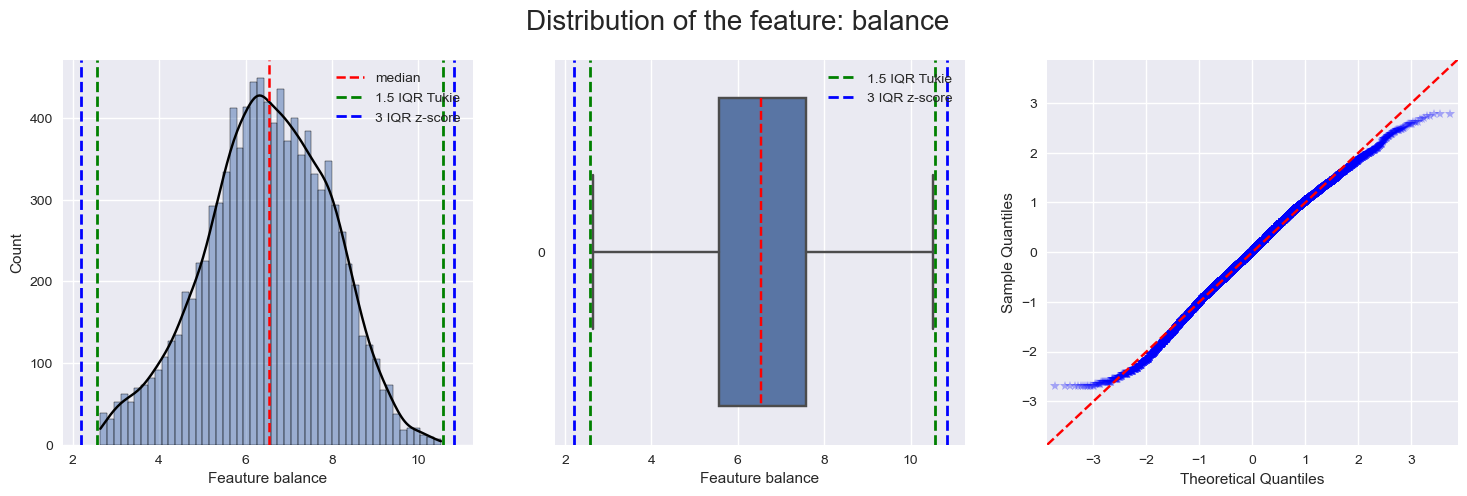

In [11]:
hist_box_qq(outliers_iqr_mode_log(np.log(abs(chapter_1_df['balance']) + 1), left=1.12, right=1.43)[1], full_iqr=True).show()

---

[to contents](#contents)

<h2><center>Часть 2: Разведывательный анализ.</center></h2>

<h3 id='sometransformationchapter2'>Начальные некоторые преобразования части 2</h3>
Хотя они должны быть в части 3, но я их сделал тут.

Преобразую столбцы `yes-no` столбцы в бинарные.<br>
Где:
* `yes` = 1
* `no` = 0

In [12]:
for i in chapter_2_df.nunique()[chapter_2_df.nunique() == 2].index:
    
    chapter_2_df[i] = chapter_2_df[i].apply(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
    
print(chapter_2_df.nunique()[chapter_2_df.nunique() == 2].index.to_list())

['default', 'housing', 'loan', 'deposit']


<h3 id='ex_2_1'>Задание 2.1</h3>

Сколько клиентов открыли депозит?

4681 клиентов открыли депозит.


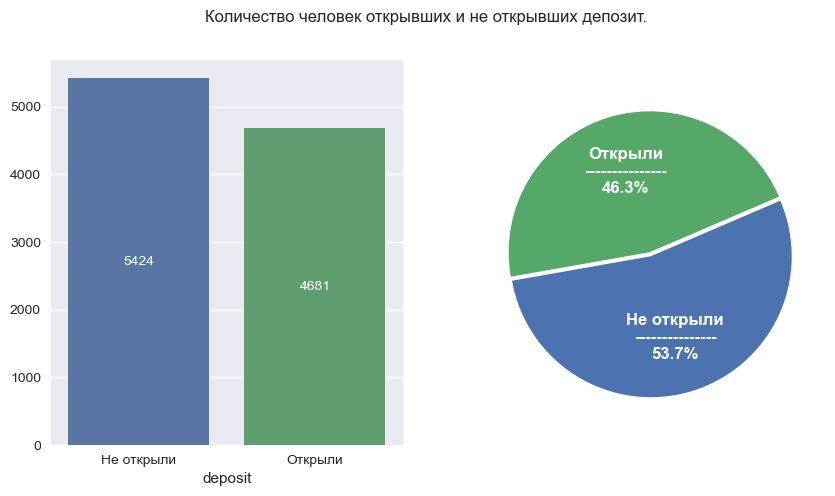

In [13]:
print(f"{chapter_2_df['deposit'].value_counts()[1]} клиентов открыли депозит.")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.countplot(chapter_2_df, x='deposit', ax=ax[0])

plt.suptitle(f'Количество человек открывших и не открывших депозит.')

ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='center', color='white')
ax[0].set_xticklabels(labels=['Не открыли', 'Открыли'])
ax[0].set_ylabel('');

def custom_autopct(pct):
    class_label = 'Не открыли' if pct > 50 else 'Открыли'
    return f'{class_label}\n---------------\n{pct:.1f}%'

ax[1].pie(chapter_2_df['deposit'].value_counts(),
          autopct=custom_autopct, explode=[0.03,0],
          textprops={'color': 'white', 'weight': 'bold', 'fontsize': 12}, startangle=190);

[to contents](#contents)

<h3 id='bonus_2_numeric'>Бонус второй части. Визуализация числовых признаков.</h3>

Начнём с описательных статистик для количественных переменных.

* Рассчитайте их и продумайте подробную интерпретацию.
* Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
* Рассмотрите минимальные и максимальные значения.
* Посмотрите на меры разброса и оцените, насколько данные вариативны.
* Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.

Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

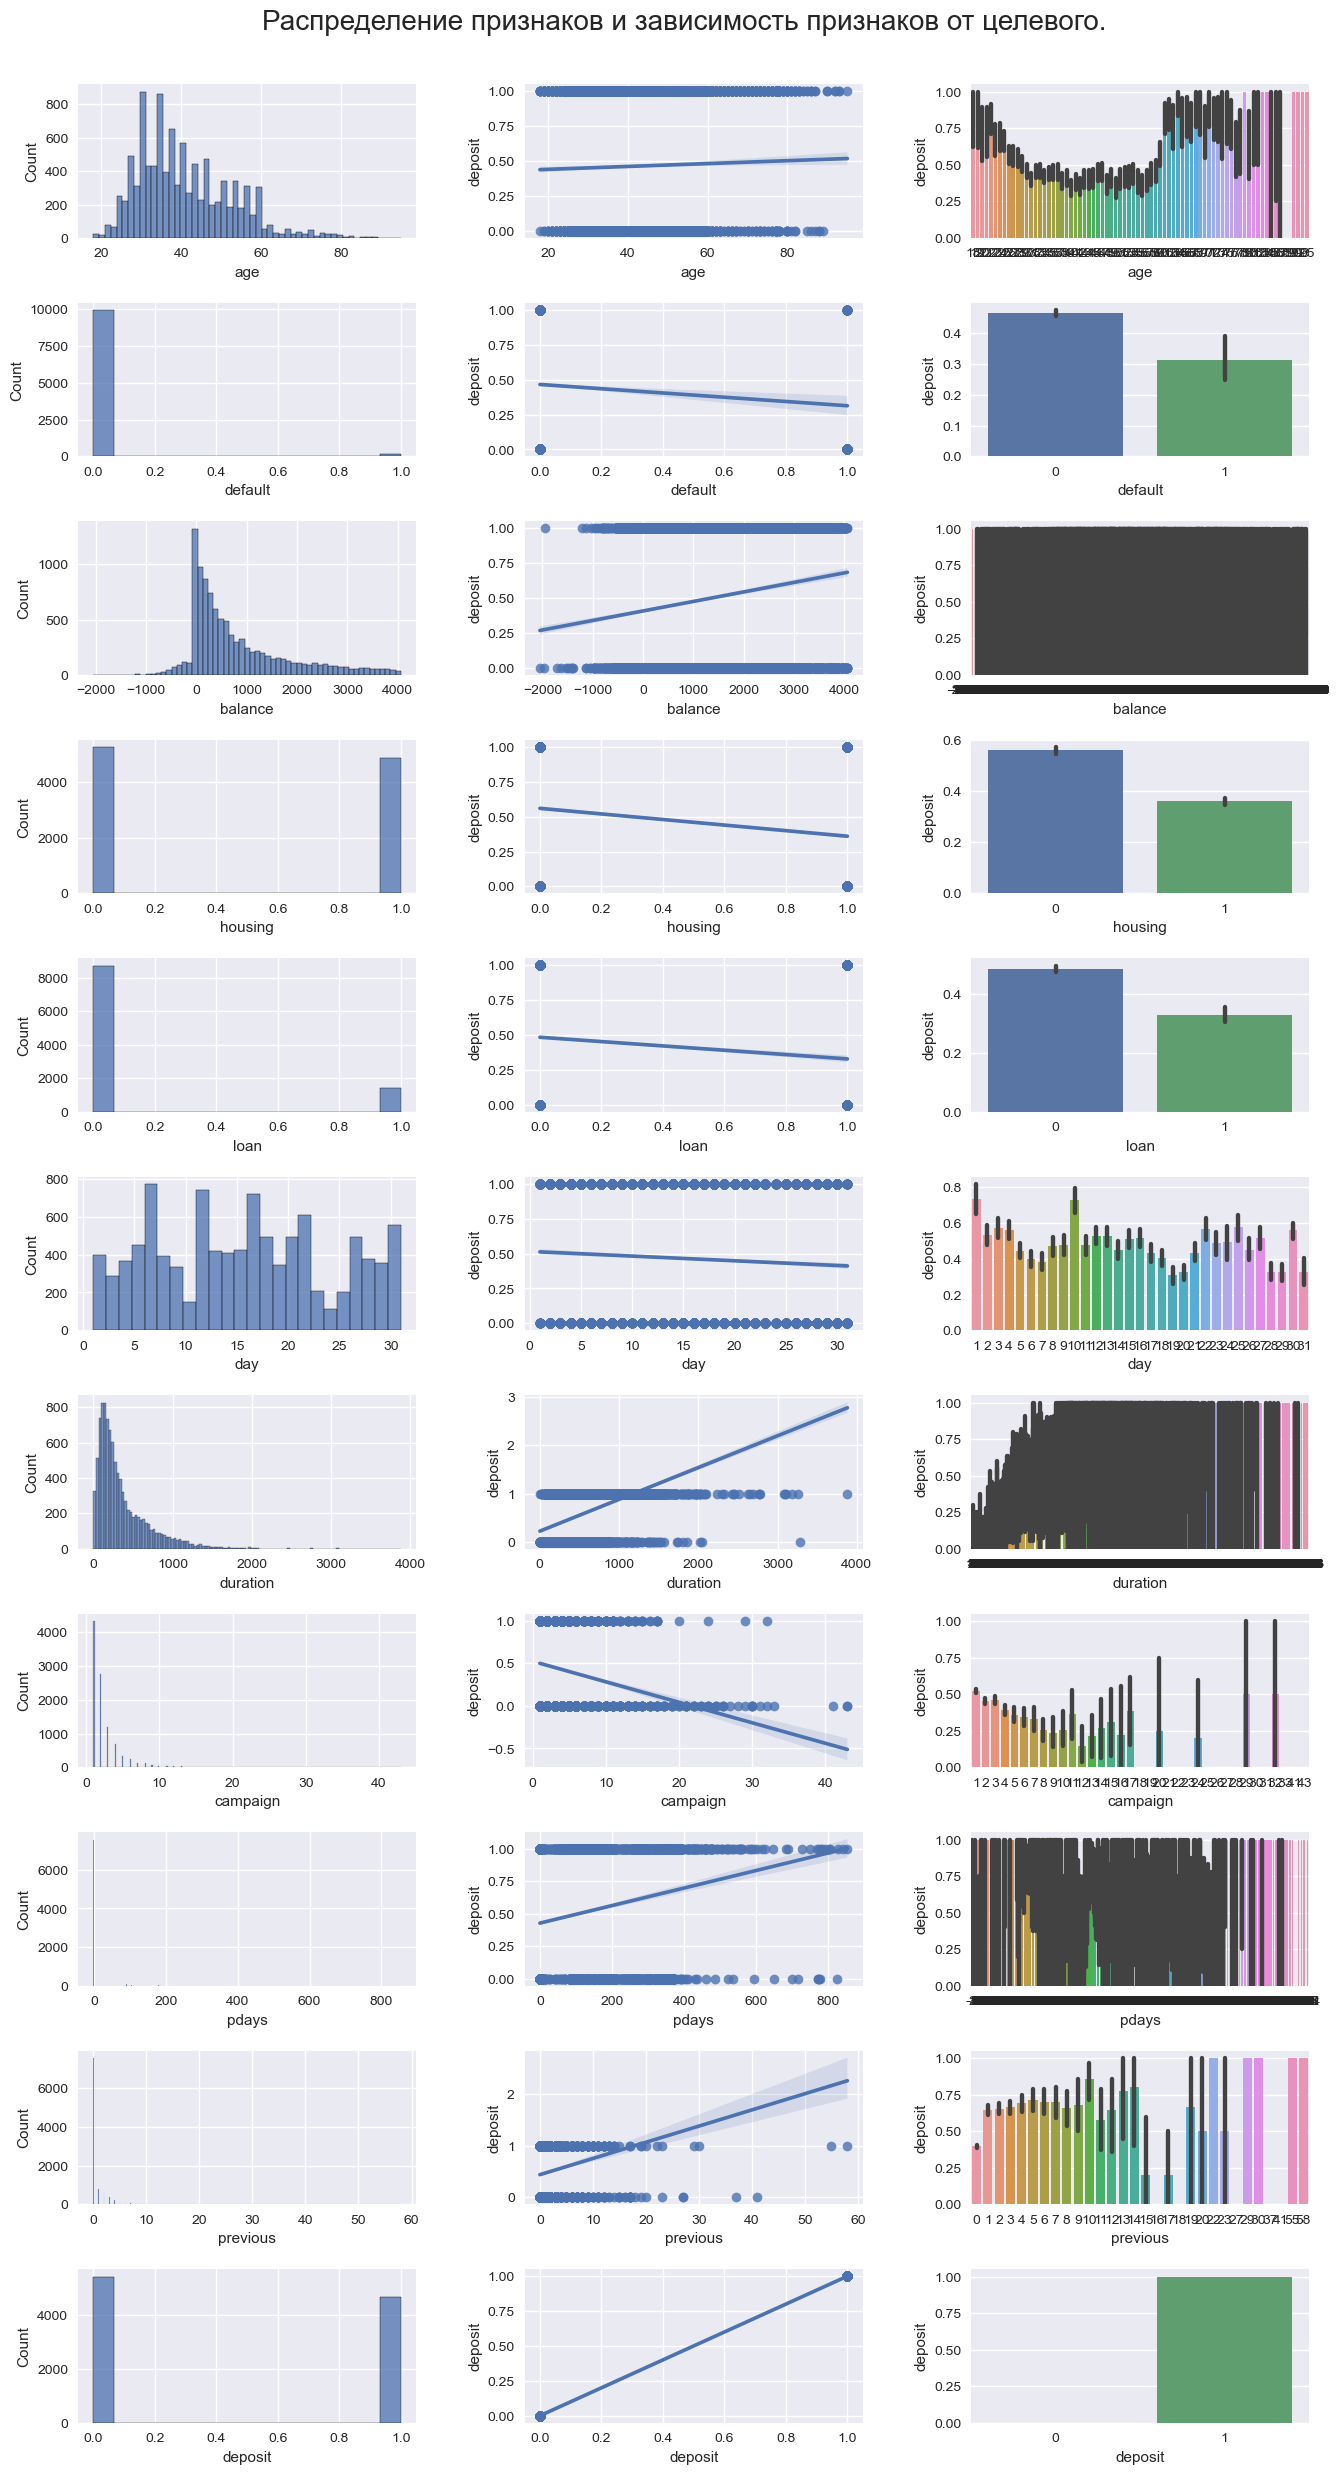

In [14]:
df_for_this_cell = chapter_2_df.select_dtypes(include='number')

fig, ax = plt.subplots(nrows=len(df_for_this_cell.columns), ncols=3, figsize=(13, 25))

fig.tight_layout(w_pad=5, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.95) # чтобы заголовок не налезал на графики

plt.suptitle('Распределение признаков и зависимость признаков от целевого.').set_fontsize(20)

for i, feature in enumerate(df_for_this_cell):
    
    sns.histplot(data=df_for_this_cell, x=feature, ax=ax[i, 0])
    sns.regplot(data=df_for_this_cell, x=feature, y='deposit', ax=ax[i, 1])
    sns.barplot(data=df_for_this_cell, x=feature, y='deposit', ax=ax[i, 2], orient='v')
    #ax[i, 2].bar_label(ax[i, 2].containers[0], fmt='%.2f', label_type='center', color='white')

Мне критически не хватает опыта для интерпретации подобных графиков помимо стандартных: 
- `balance`, `duration` и `previous` похожи на логнормальные признаки;
- у большинства признаков приличная корреляция с целевым;
- люди с кредитами реже соглашаются на открытие депозита;
- люди среднего возраста реже соглашаются на открытие депозита, чем люди молодого и "старого" (прошу прощения) возрастов;
- есть дни, в которые прям очень хорошо открываются депозиты, а есть дни (абстрактно) ретроградного меркурия;
- не понятно, что с `pdays`.

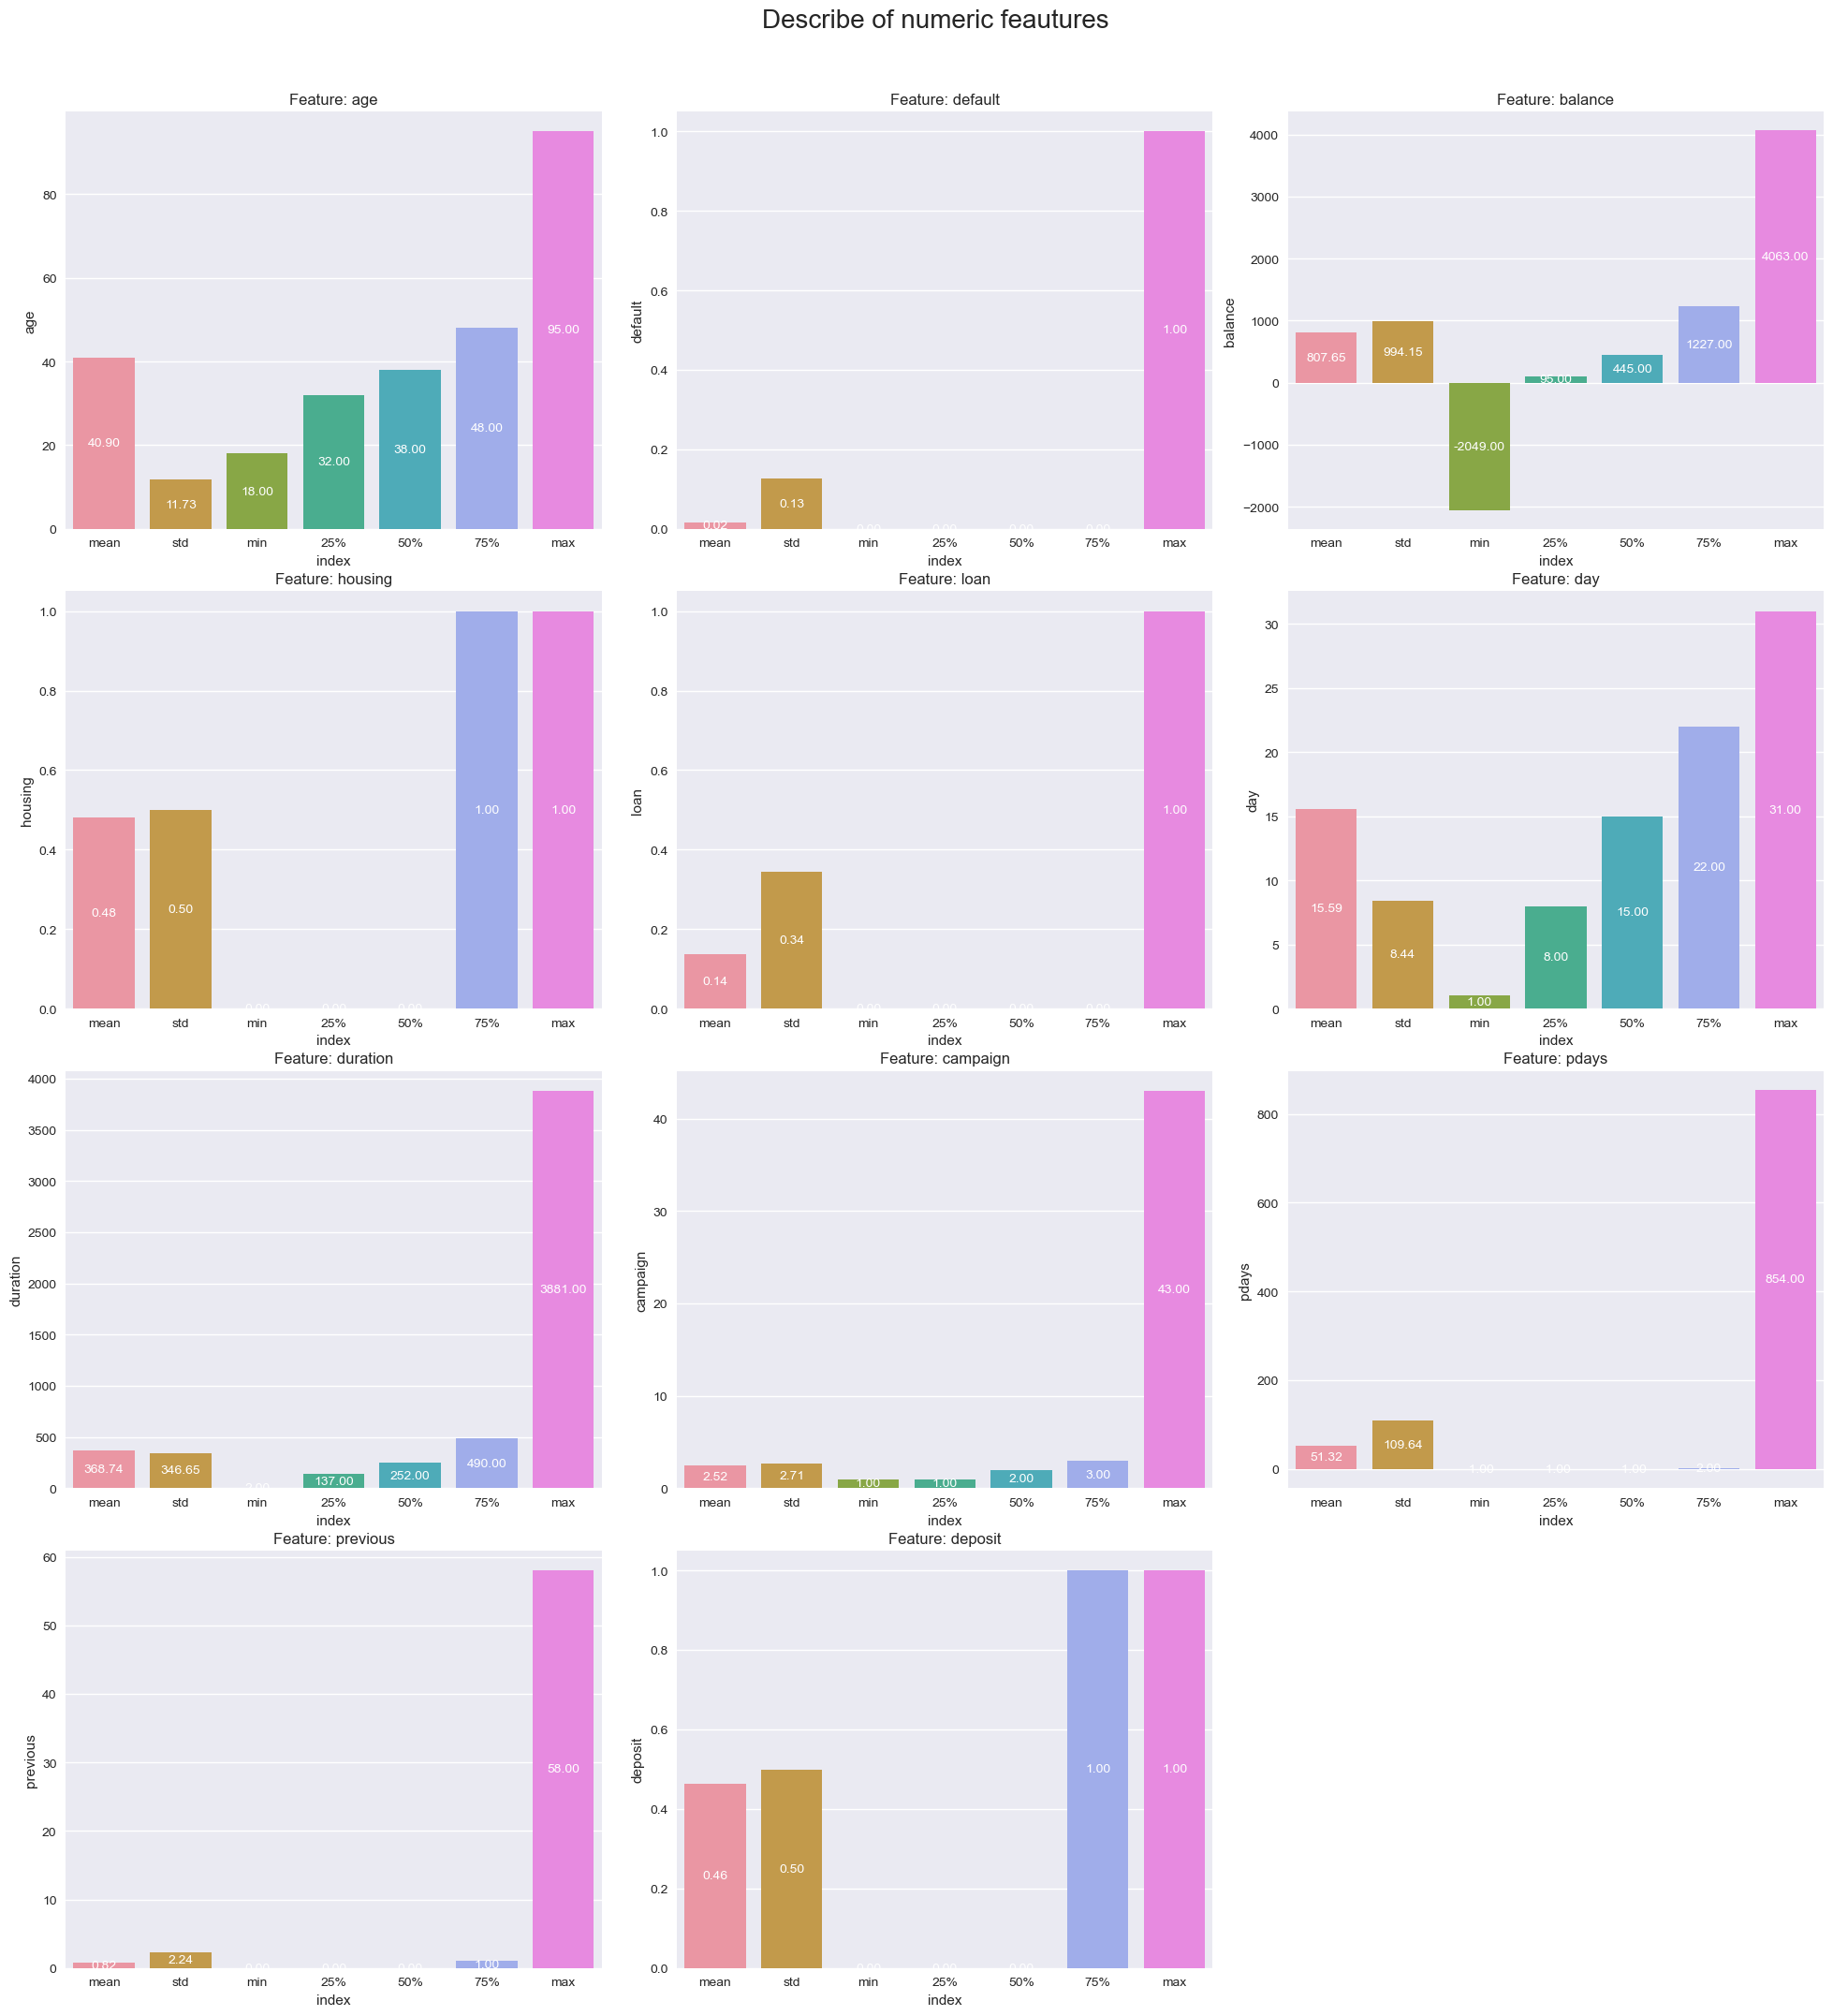

In [14]:
df_for_this_cell = chapter_2_df.select_dtypes(include='number').describe().drop('count')

ncols = 3
nrows = (df_for_this_cell.shape[1] + 2) // ncols 
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 22))

plt.suptitle('Describe of numeric feautures', fontsize=20)

fig.tight_layout(pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.93) # чтобы заголовок не налезал на графики

for idx, feature in enumerate(df_for_this_cell.columns):
    row = idx // ncols
    col = idx % ncols
    
    sns.barplot(data=df_for_this_cell[feature].reset_index(), x='index', y=feature, ax=ax[row, col])
    ax[row, col].set_title(f'Feature: {feature}')
    ax[row, col].bar_label(ax[row, col].containers[0], fmt='%.2f', label_type='center', color='white')
    
# Удаляем пустые subplot'ы
for i in range(len(df_for_this_cell.columns), nrows*ncols):
    row = i // ncols
    col = i % ncols
    fig.delaxes(ax[row, col])

plt.show()

По дескрайбу... Копипастну текст из чата гпт, т.к. сам дуб дубом.)))

* Вариативность данных: Высокое стандартное отклонение в столбцах `balance`, `duration` и `pdays` указывает на значительные колебания значений внутри этих переменных. В то время как `age`, `day`, `campaign` и `previous` имеют меньшую вариативность.

* Аномальные значения:

    * В столбце `balance` есть как отрицательные значения, так и высокие положительные значения, что может свидетельствовать о задолженности или высоких остатках на счетах.
    * В столбце `duration` максимальное значение сильно превышает 75-й процентиль, что указывает на возможные аномально долгие звонки.
    * В столбце `campaign` максимальное значение также значительно превышает 75-й процентиль, что может быть связано с аномально большим числом контактов с клиентами.

Данные показывают высокую степень вариативности в определенных столбцах, что может требовать более тщательного анализа, особенно для выявления и обработки аномальных значений.

[to contents](#contents)

<h3 id='ex_2_2'>Задание 2.2</h3>

Каков максимальный возраст клиента банка?

In [15]:
print(f"Максимальный возраст клиента банка: {chapter_2_df['age'].max()}")

Максимальный возраст клиента банка: 95


График распределения признака `age` после удаления выбросов.

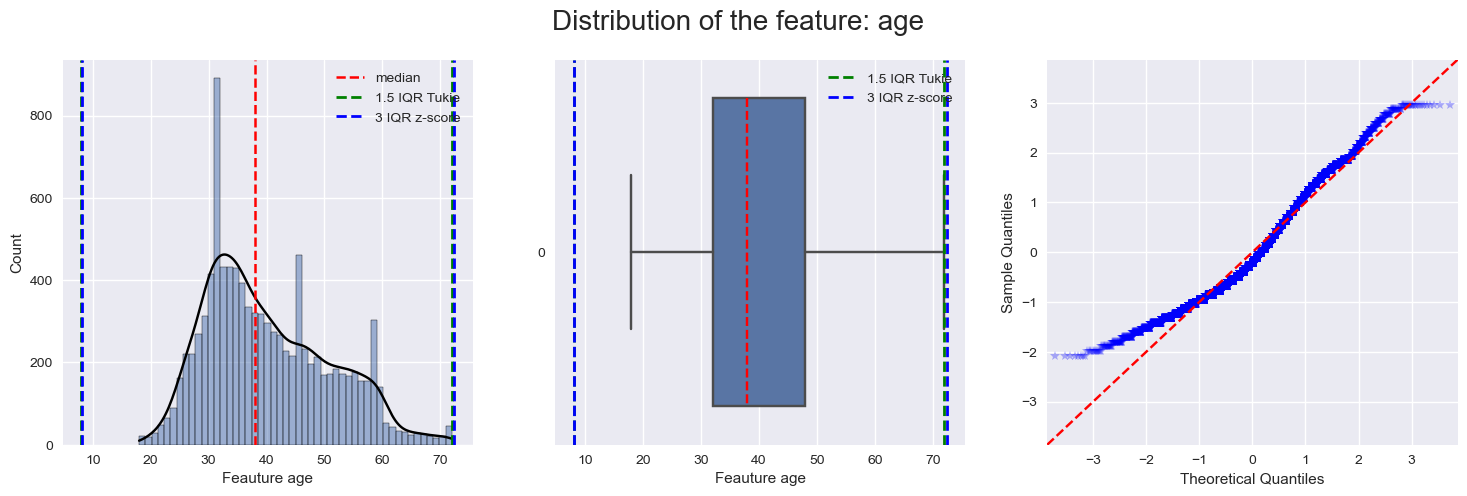

In [16]:
hist_box_qq(outliers_iqr_mode_log(chapter_2_df['age'], right=1.56)[1], full_iqr=True).show()

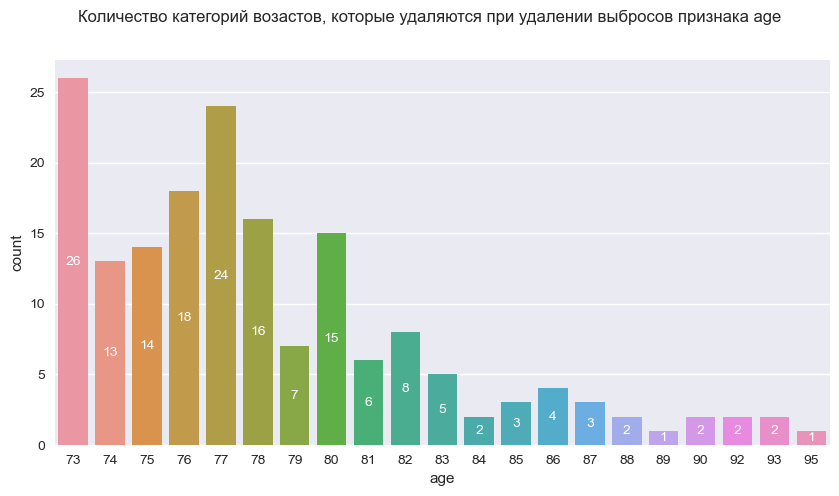

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('Количество категорий возастов, которые удаляются при удалении выбросов признака age')
sns.barplot(data=outliers_iqr_mode_log(chapter_2_df['age'], right=1.56)[0].value_counts().sort_index().reset_index(), x='age', y='count')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='center', color='white');

Подобные графики я оставляю для себя, как тренировку понимания подобных графиков.)

[to contents](#contents)

<h3 id='ex_2_3'>Задание 2.3</h3>

Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.

In [18]:
print(f"Минимальная продолжительность разговора: {chapter_2_df['duration'].min()} сек.")

Минимальная продолжительность разговора: 2 сек.


График распределения признака `duration` после удаления выбросов и логарифмирования.

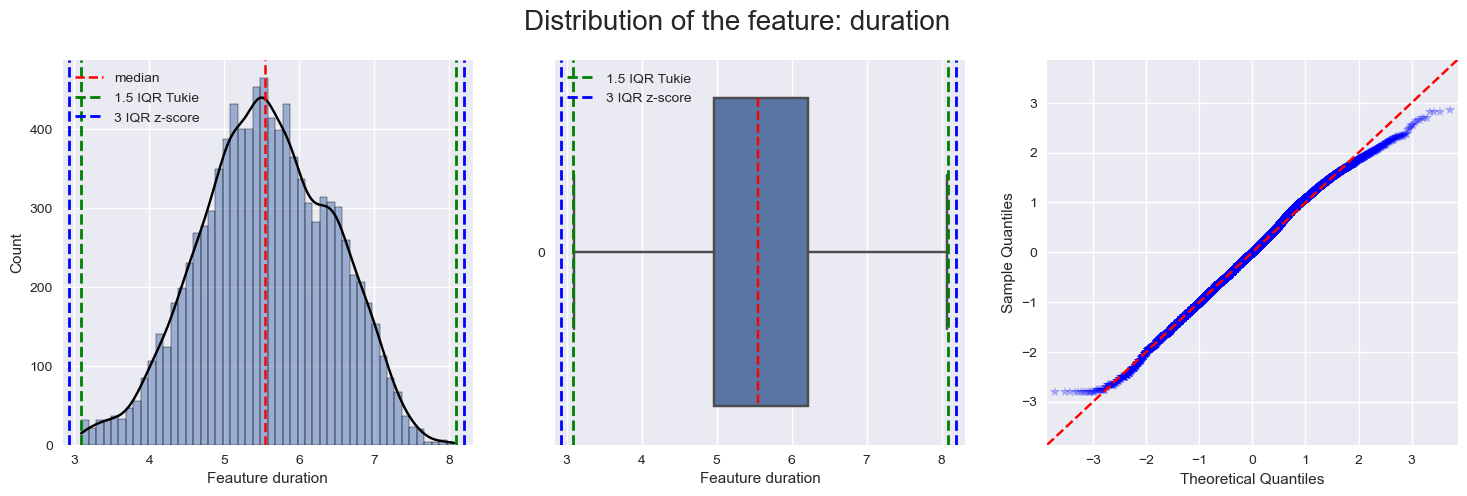

In [19]:
hist_box_qq(outliers_iqr_mode_log(np.log(chapter_2_df['duration']), left=1.47, right=1.48)[1], full_iqr=True).show()

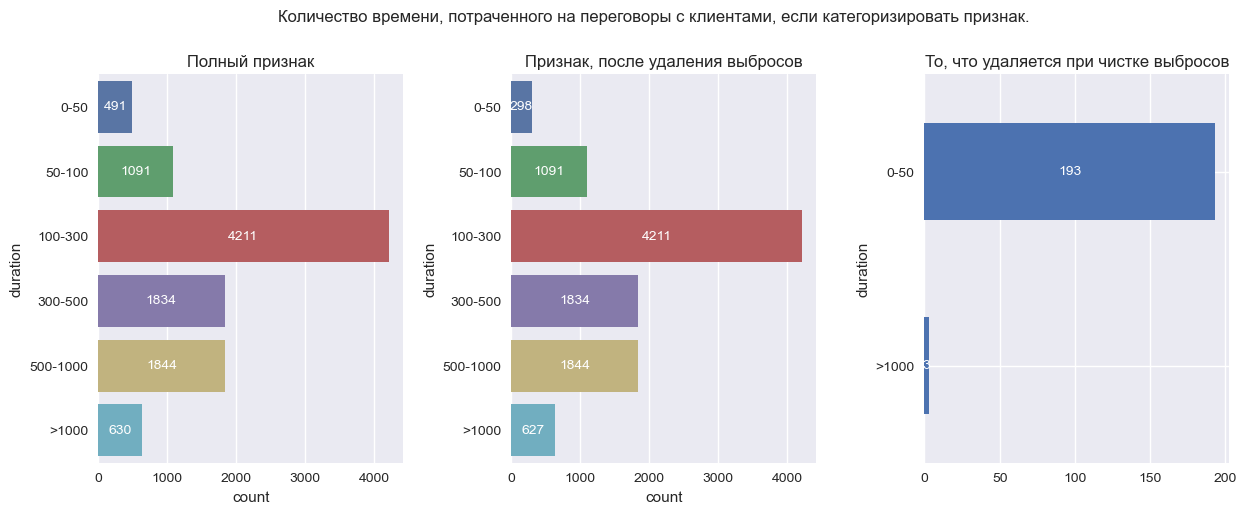

In [20]:
lambda_for_duration = lambda x: \
    '0-50' if x < 50 else\
        '50-100' if x >= 50 and x < 100 else\
            '100-300' if x >= 100 and x < 300 else\
                '300-500' if x >= 300 and x < 500 else\
                    '500-1000' if x >= 500 and x < 1000 else\
                        '>1000' if x >+ 1000 else x
index_order_duration = ['0-50', '50-100', '100-300', '300-500', '500-1000', '>1000']

# Здесь можно поменять границы выбросов.
tuple_of_dfs_for_this_cell = outliers_iqr_mode_log(data=chapter_2_df, feature='duration', log_scale=True, left=1.47, right=1.48)

######## Графики
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.suptitle('Количество времени, потраченного на переговоры с клиентами, если категоризировать признак.')

fig.tight_layout(w_pad=5, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.85) # чтобы заголовок не налезал на графики

###### График 1
sns.barplot(data=chapter_2_df['duration']\
    .apply(lambda_for_duration)\
        .value_counts()\
            .reindex(index_order_duration)\
                .reset_index(),
            x='count', y='duration', orient='h', ax=ax[0])
ax[0].set_title('Полный признак')
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='center', color='white')

###### График 2
sns.barplot(data=tuple_of_dfs_for_this_cell[1]['duration']\
    .apply(lambda_for_duration)\
        .value_counts()\
            .reindex(index_order_duration)\
                .reset_index(),
            x='count', y='duration', orient='h', ax=ax[1])
ax[1].set_title('Признак, после удаления выбросов')
ax[1].bar_label(ax[1].containers[0], fmt='%.0f', label_type='center', color='white')

###### График 3
tuple_of_dfs_for_this_cell[0]['duration']\
    .apply(lambda_for_duration)\
        .value_counts(ascending=True)\
            .plot(kind='barh', ax=ax[2])
ax[2].set_title('То, что удаляется при чистке выбросов')
ax[2].bar_label(ax[2].containers[0], fmt='%.0f', label_type='center', color='white');

Меня триггерят выбросы, т.к. пока я не умею с ними правильно работать. Этот график лишний, но решил сделать, захотелось.

[to contents](#contents)

<h3 id='bonus_2_category'>Бонус второй части. Визуализация категориальных признаков.</h3>

<img src='projectpics/proj4pic2.png' width='70%' style='display:block; margin:auto;'>

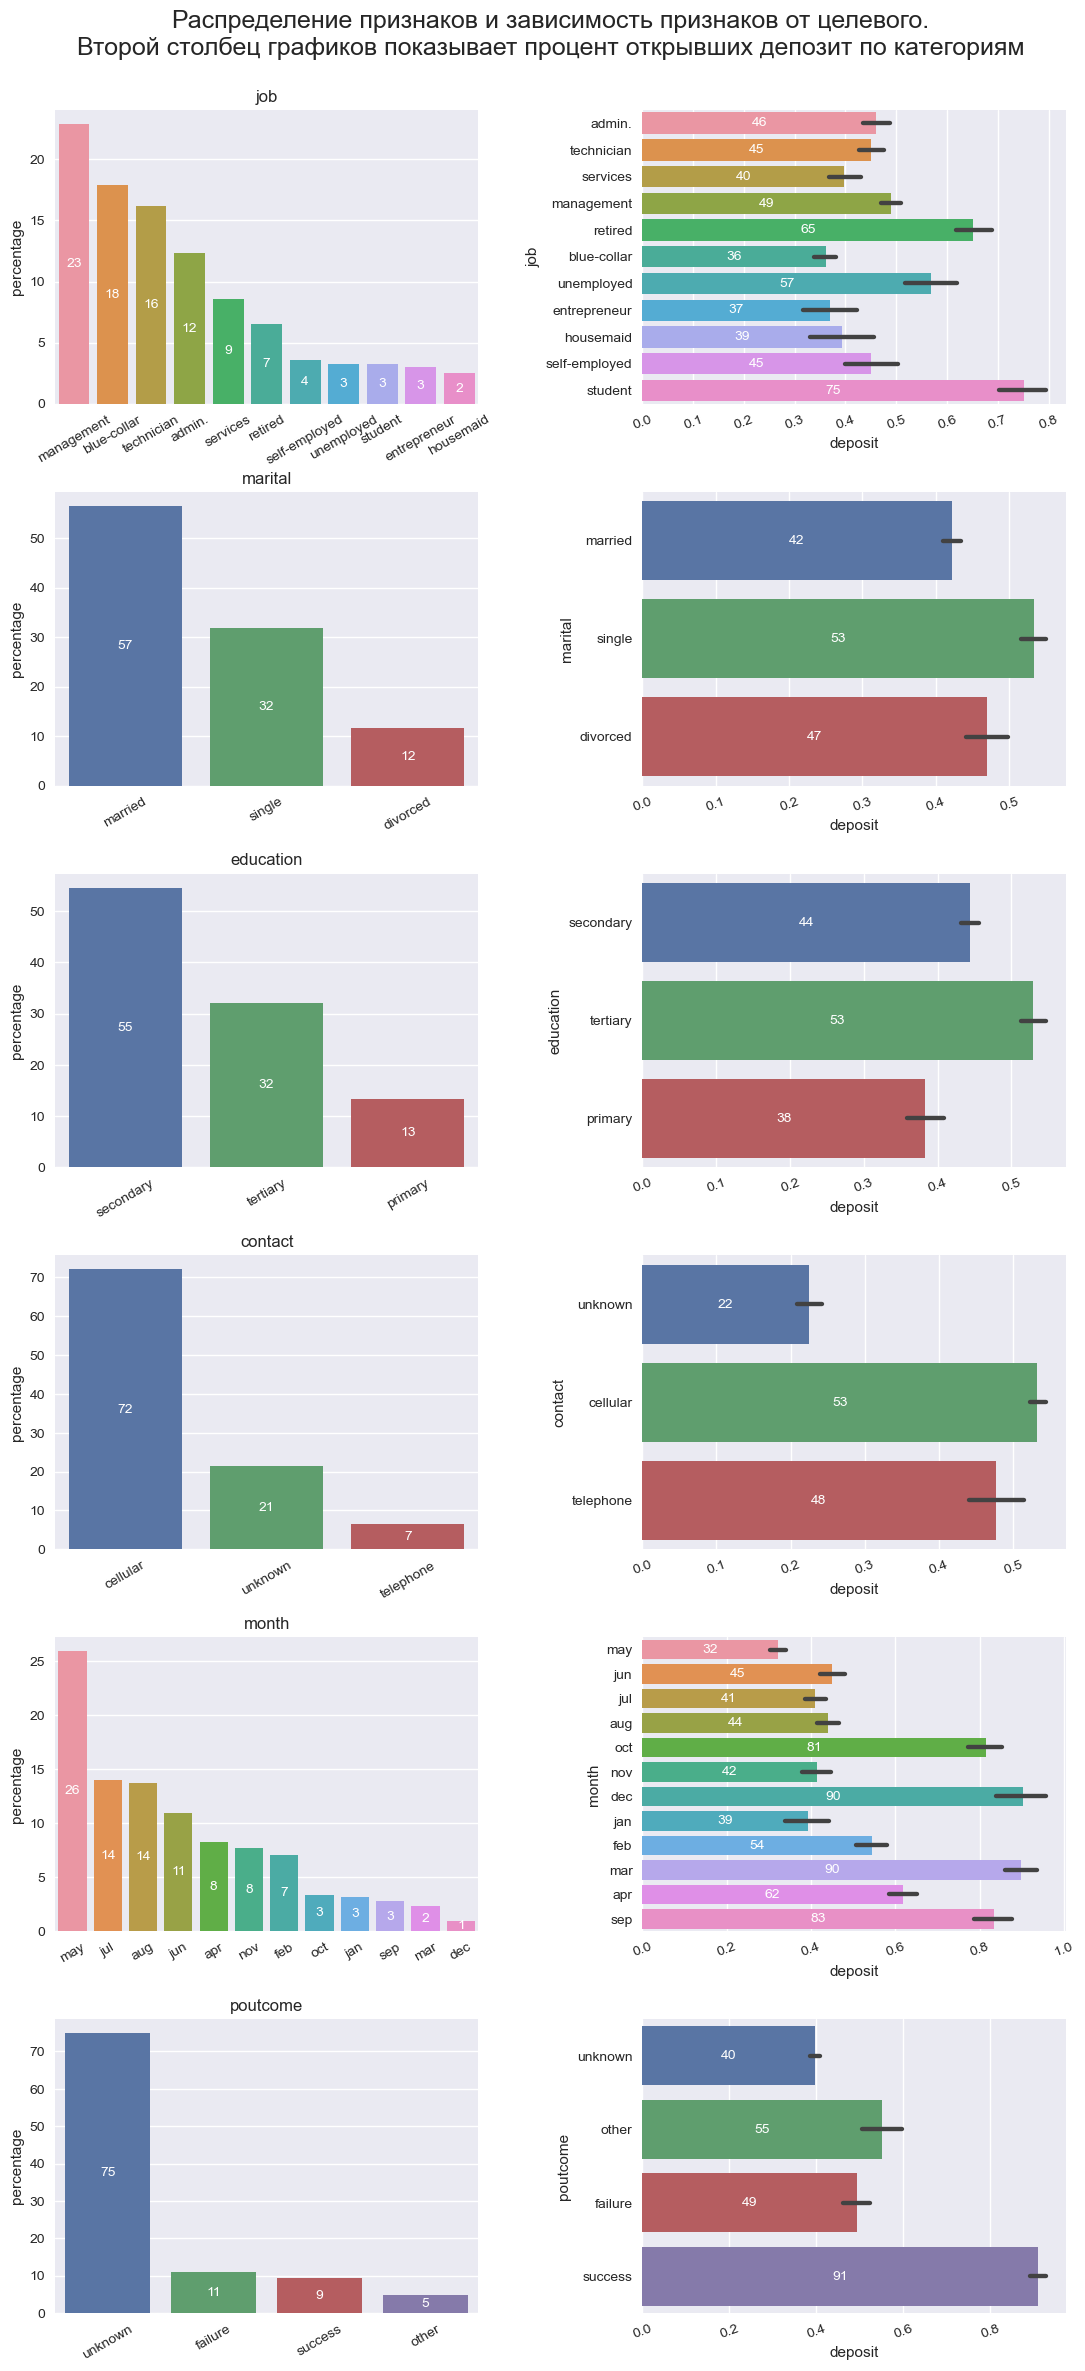

In [21]:
df_for_this_cell = chapter_2_df.select_dtypes(include='object')

fig, ax = plt.subplots(nrows=len(df_for_this_cell.columns), ncols=2, figsize=(13, 25))

plt.suptitle('Распределение признаков и зависимость признаков от целевого.\nВторой столбец графиков показывает процент открывших депозит по категориям').set_fontsize(18)

fig.tight_layout(pad=9, h_pad=4) # расстояние между подграфиками
plt.subplots_adjust(top=0.94) # чтобы заголовок не налезал на графики

# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(list(df_for_this_cell.columns)):
    
    series_for_this_loop = (df_for_this_cell[feature].value_counts(normalize=True)*100)\
                                                     .sort_values(ascending=False)\
                                                     .rename('percentage')\
                                                     .reset_index()
    
    # Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_barplot = sns.barplot(data=series_for_this_loop, x=series_for_this_loop[feature], y='percentage', ax=ax[i, 0])
    
    count_barplot.xaxis.set_tick_params(rotation=30)
    count_barplot.set_xlabel('')
    count_barplot.set_title(f"{feature}")
    count_barplot.bar_label(count_barplot.containers[0], fmt='%.0f', label_type='center', color='white')
    
    # Строим столбчатую диаграмму доли людей зарабатывающих открывших депозит в зависимости от категории
    mean_barplot = sns.barplot(data=chapter_2_df, x='deposit', y=feature, ax=ax[i, 1], orient='h')
    mean_barplot.xaxis.set_tick_params(rotation=20)
    # Тут пришлось изъебнуться, т.к. текст контейнера был в долях
    [i.set_text(f'{float(i.get_text()) * 100:.0f}') for i in mean_barplot.bar_label(mean_barplot.containers[0], label_type='center', color='white')]

По категориальным признакам:
- больше всего соглашаются на открытие депозита студены, люди в отставке (`retired`) и безработные;
- на депозиты больше соглашаются одинокие и разведённые, хотя людей, находящихся в браке - большинство;
- люди с высшим образованием больше склонны открыть депозит, чем с `secondary` и `primary`, с преобладающим большинством в `secondary`;
- по стационарницу люди чаще соглашаются на депозит, чем по мобильному;
- март, сентябрь, октябрь, декабрь - прекрасные месяцы для того, чтоб развести кого-то на депозит и май - самый не очень;
- ну и конечно же успеха гораздо больше, чем неудач (в плане открытия депозита) в признаке `poutcome` с преобладающим большинством неизвестных значений, закодированных словом `unknown`, что говорит нам, что это признак необходимо как-то обрабатывать.

[to contents](#contents)

<h3 id='ex_2_4'>Задание 2.4</h3>

Сколько было месяцев, в которых проводилась маркетинговая кампания?

In [21]:
print(f"Маркетинговая кампания проводилась во всех {len(chapter_2_df['month'].value_counts().sort_values(ascending=True).index)}-ти месяцах.")

Маркетинговая кампания проводилась во всех 12-ти месяцах.


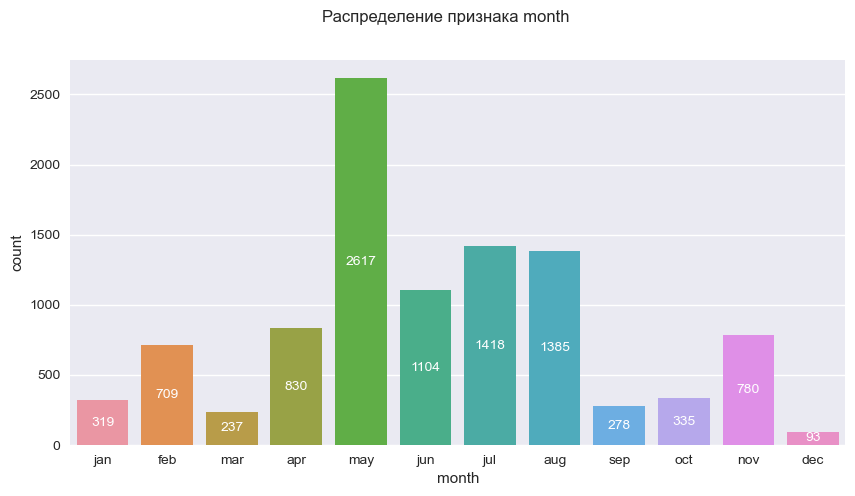

In [22]:
index_order_month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('Распределение признака month')
sns.barplot(data=chapter_2_df['month'].value_counts()\
                                      .sort_values(ascending=False)\
                                      .reindex(index_order_month)\
                                      .reset_index(), x='month', y='count')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='center', color='white');

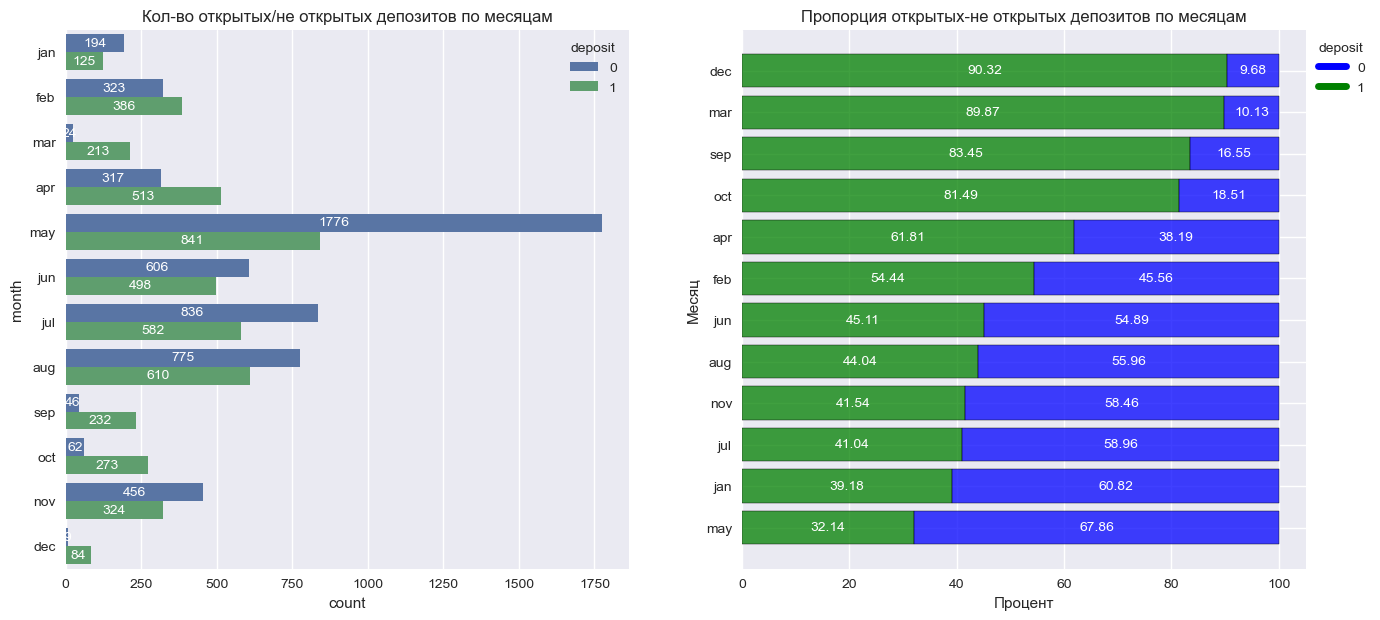

In [23]:
##### Дата к графикам
df_for_this_cell_1 = chapter_2_df.groupby('month')['deposit'].value_counts()\
                                                             .unstack()\
                                                             .reindex(index_order_month)\
                                                             .stack()\
                                                             .reset_index(name='count')
                                                             
df_for_this_cell_2 = (chapter_2_df.groupby('month')['deposit'].value_counts(normalize=True) * 100).unstack().sort_values(0).reset_index()
melted_df_ftc_2 = df_for_this_cell_2.melt(id_vars='month', value_name='Процент')

######## Графики
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

# Первый
sns.barplot(df_for_this_cell_1, y='month', x='count', hue='deposit', orient='h', ax=ax[0])
[ax[0].bar_label(ax[0].containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax[0].containers))]

# Второй
sns.histplot(data=melted_df_ftc_2, y='month', hue='deposit', weights='Процент', multiple='stack', palette=['blue', 'green'], shrink=.8, ax=ax[1])
[ax[1].bar_label(ax[1].containers[i], fmt='%.2f', label_type='center', color='white') for i in range(len(ax[1].containers))]

# Настройка внешнего вида
ax[0].set_title('Кол-во открытых/не открытых депозитов по месяцам')
ax[1].set_title('Пропорция открытых-не открытых депозитов по месяцам')
ax[1].set_xlabel('Процент')
ax[1].set_ylabel('Месяц')

custom_lines = [plt.Line2D([0], [0], color='blue', lw=5),
                plt.Line2D([0], [0], color='green', lw=5)]

ax[1].legend(custom_lines, ['0', '1'], title='deposit', bbox_to_anchor=(1, 1))

plt.show()

[to contents](#contents)

<h3 id='ex_2_5'>Задание 2.5</h3>

Сколько сфер занятости представлено среди клиентов банка?

In [24]:
print(f"Среди клиентов банка представлено {len(chapter_2_df['job'].value_counts().index)} сфер занятости.")

Среди клиентов банка представлено 11 сфер занятости.


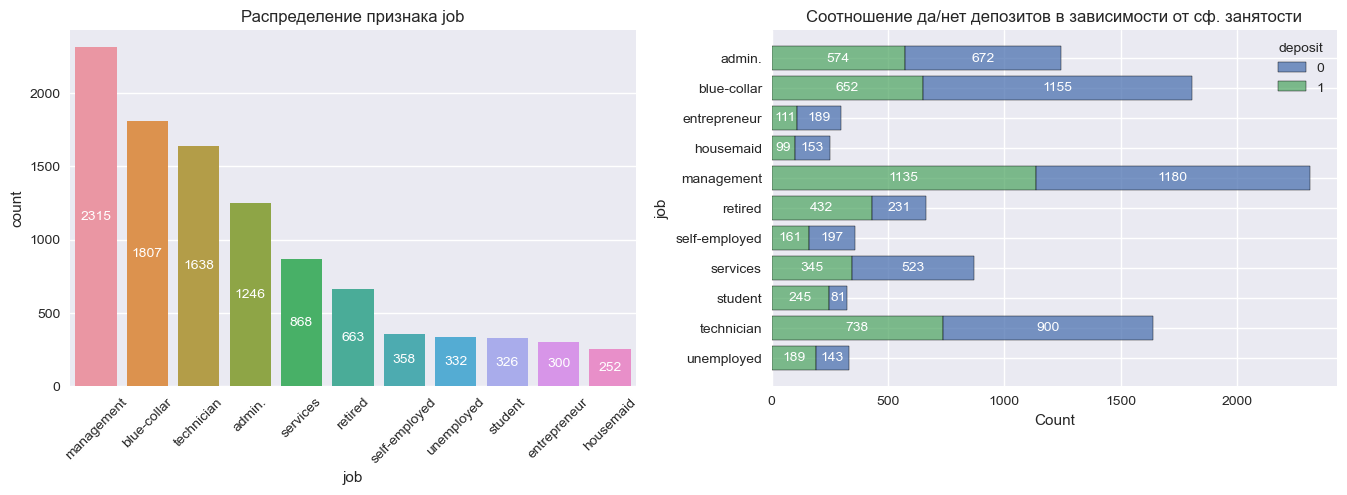

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.tight_layout(pad=7, h_pad=4) # расстояние между подграфиками
plt.subplots_adjust(top=0.95) # чтобы заголовок не налезал на графики

sns.barplot(chapter_2_df['job'].value_counts().reset_index(), x='job', y='count', ax=ax[0])

sns.histplot(chapter_2_df.groupby('job')['deposit'].value_counts().reset_index(), y='job', weights='count', hue='deposit', multiple='stack', shrink=.8, ax=ax[1])
[ax[1].bar_label(ax[1].containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax[1].containers))]

ax[0].set_title('Распределение признака job')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='center', color='white')
ax[1].set_title('Соотношение да/нет депозитов в зависимости от сф. занятости');

[to contents](#contents)

<h3 id='ex_2_6'>Задание 2.6</h3>

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

Статус, в котором успехов намного больше, чем неудач: success


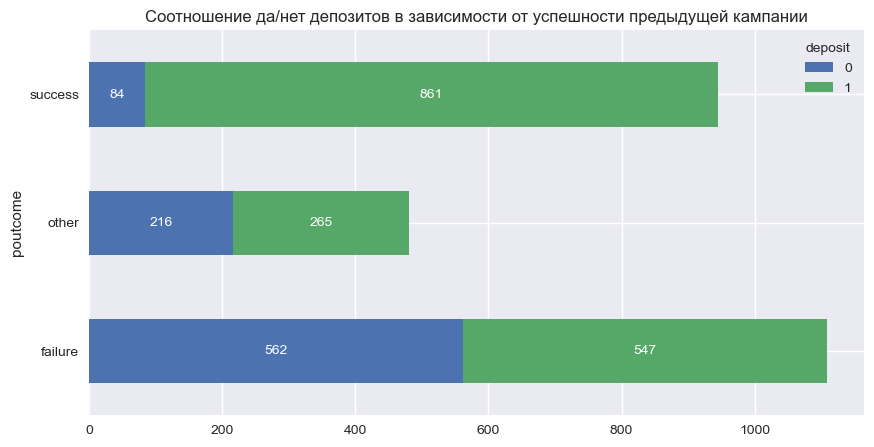

In [26]:
print(f"Статус, в котором успехов намного больше, чем неудач: {chapter_2_df.groupby('poutcome')['deposit'].value_counts().index[4][0]}")

fig, ax = plt.subplots(figsize=(10, 5))
types = chapter_2_df.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack().drop('unknown')
types.plot(kind='barh', stacked='True', ax=ax);
[ax.bar_label(ax.containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax.containers))]
ax.set_title('Соотношение да/нет депозитов в зависимости от успешности предыдущей кампании');

[to contents](#contents)

<h3 id='ex_2_7'>Задание 2.7</h3>

Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

Месяц самого большого процента неудач: may


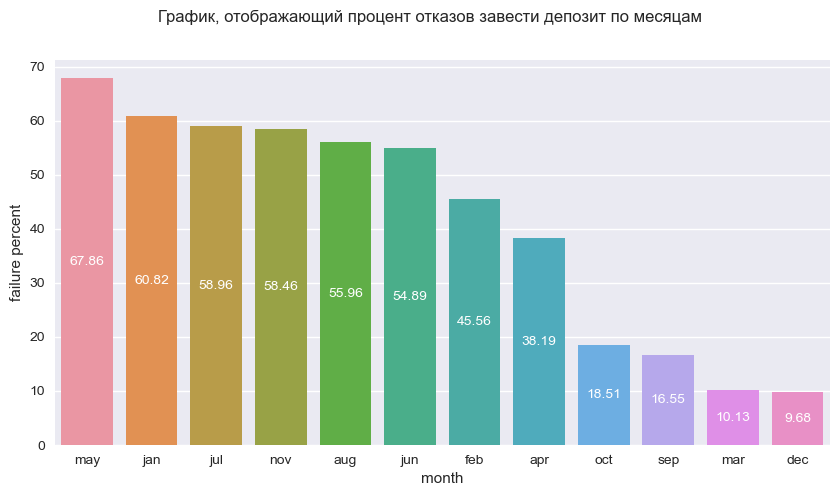

In [27]:
series_for_this_cell = ((chapter_2_df[chapter_2_df['deposit'] == 0].groupby('month')['deposit'].count() / chapter_2_df.groupby('month')['deposit'].count()) * 100).sort_values(ascending=False)

print(f"Месяц самого большого процента неудач: {series_for_this_cell[series_for_this_cell == series_for_this_cell.max()].index[0]}")

fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('График, отображающий процент отказов завести депозит по месяцам')
sns.barplot(series_for_this_cell.reset_index(), x='month', y='deposit')
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='center', color='white')
ax.set_ylabel('failure percent');

[to contents](#contents)

<h3 id='ex_2_8'>Задание 2.8</h3>

<img src='projectpics/proj4pic3.png' width='70%' style='display:block; margin:auto;'>

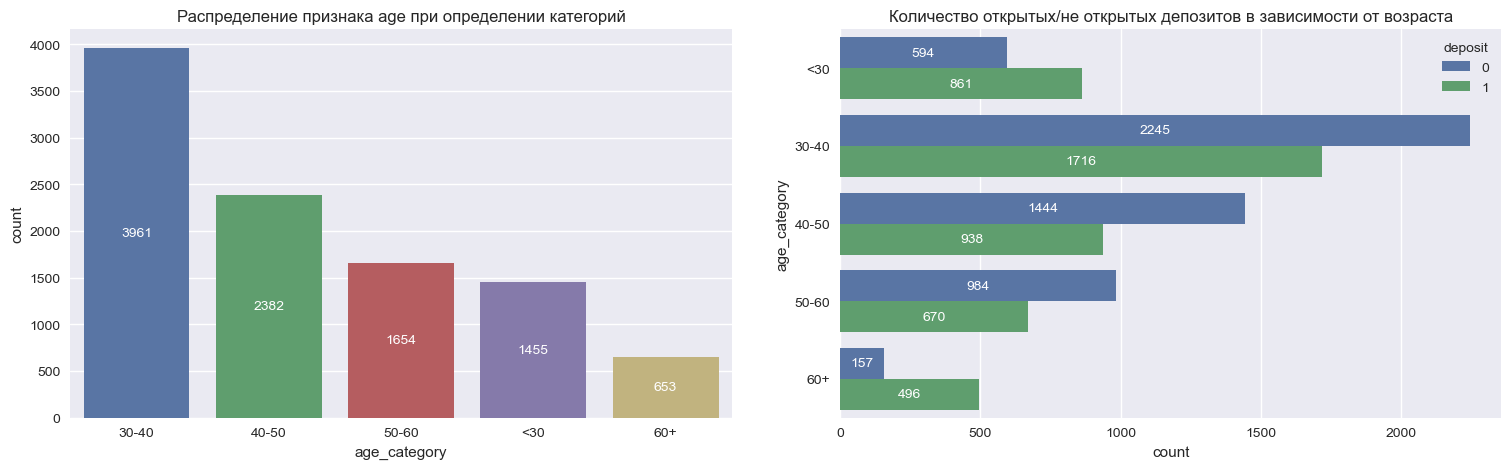

In [28]:
lambda_for_age = lambda x: \
    '<30' if x < 30 else\
        '30-40' if x >= 30 and x < 40 else\
            '40-50' if x >= 40 and x < 50 else\
                '50-60' if x >= 50 and x < 60 else\
                    '60+' if x >= 60 else x
index_order_age = ['<30', '30-40', '40-50', '50-60', '60+']

chapter_2_df['age_category'] = chapter_2_df['age'].apply(lambda_for_age)
#chapter_2_df['age_category'] = pd.cut(chapter_2_df['age'], bins=[0, 30, 40, 50, 60, 999], labels=index_order_age)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

fig.tight_layout(w_pad=5, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.85) # чтобы заголовок не налезал на графики
              
sns.barplot(chapter_2_df['age_category'].value_counts().reset_index(), x='age_category', y='count', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='center', color='white')
ax[0].set_title('Распределение признака age при определении категорий')

df_for_second_plot = chapter_2_df.groupby(['age_category', 'deposit'])['deposit'].count().unstack().reindex(index_order_age).stack().reset_index(name='count')
sns.barplot(df_for_second_plot, x='count', y='age_category', hue='deposit', ax=ax[1], orient='h')
[ax[1].bar_label(ax[1].containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax[1].containers))];
ax[1].set_title('Количество открытых/не открытых депозитов в зависимости от возраста');

Здесь оставлю коммент о методе `pd.cut()`, который используется в оригинальном решении данного проекта и не используется мной.<br>
Так вот, `pd.cut()` не совсем корректно распределяет числа по категориям, согласно условиям задачи. Оставлю скрин.

<img src='projectpics/pdcut.png' width='70%' style='display:block; margin:auto;'>

[to contents](#contents)

<h3 id='ex_2_9'>Задание 2.9</h3>

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

В какой сфере занято наибольшее число клиентов банка?

Наибольшее число клиентов банка заняты в сфере: management


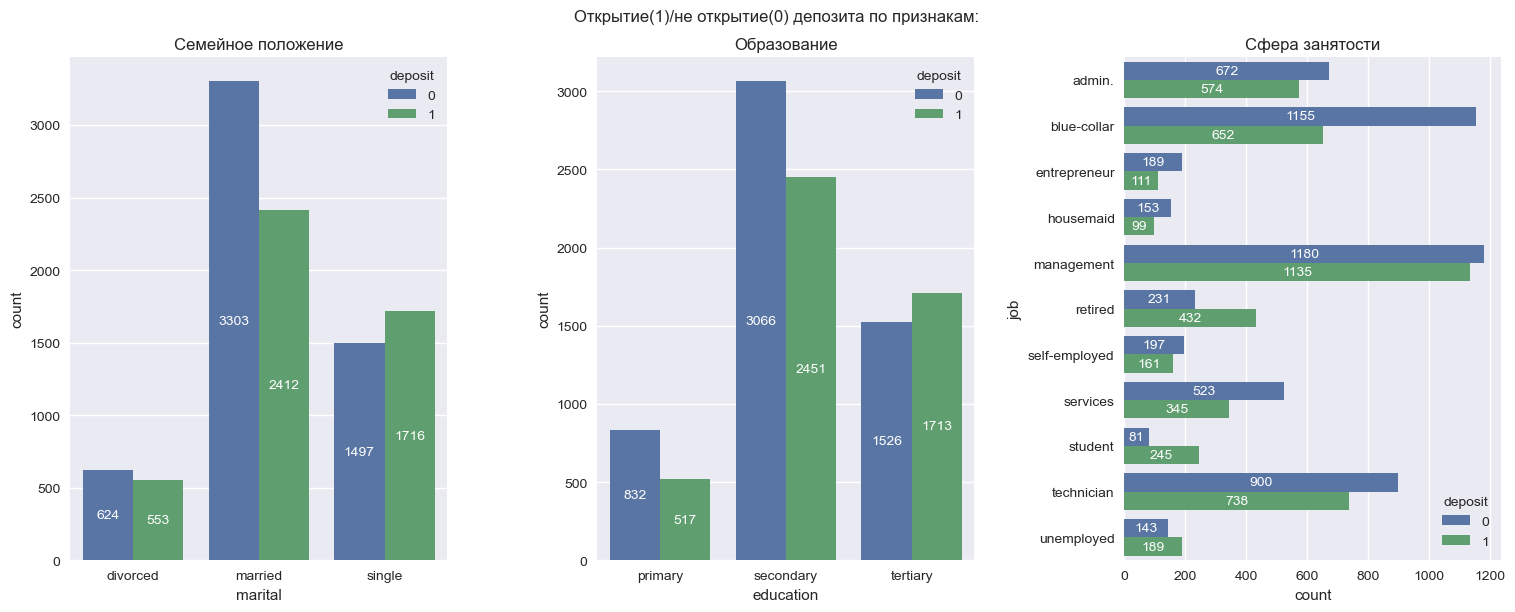

In [29]:
print(f"Наибольшее число клиентов банка заняты в сфере: {chapter_2_df.groupby('job')['deposit'].count().sort_values(ascending=False).index[0]}")

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 6))

fig.tight_layout(w_pad=8, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.9) # чтобы заголовок не налезал на графики

plt.suptitle('Открытие(1)/не открытие(0) депозита по признакам:')

sns.barplot(chapter_2_df.groupby(['marital', 'deposit'])['deposit'].count().reset_index(name='count'), x='marital', y='count', hue='deposit', ax=ax[0])
[ax[0].bar_label(ax[0].containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax[0].containers))]
ax[0].set_title('Семейное положение')

sns.barplot(chapter_2_df.groupby(['education', 'deposit'])['deposit'].count().reset_index(name='count'), x='education', y='count', hue='deposit', ax=ax[1])
[ax[1].bar_label(ax[1].containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax[1].containers))]
ax[1].set_title('Образование')

sns.barplot(chapter_2_df.groupby(['job', 'deposit'])['deposit'].count().reset_index(name='count'), y='job', x='count', hue='deposit', orient='h', ax=ax[2])
[ax[2].bar_label(ax[2].containers[i], fmt='%.0f', label_type='center', color='white') for i in range(len(ax[2].containers))]
ax[2].set_title('Сфера занятости');

[to contents](#contents)

<h3 id='ex_2_10'>Задание 2.10</h3>

При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

In [30]:
df_for_this_cell = chapter_2_df.groupby(['marital', 'deposit'])['deposit'].count().reset_index(name='count')
merge_for_this_cell = pd.merge(df_for_this_cell[df_for_this_cell['deposit'] == 1].drop('deposit', axis=1),
                               df_for_this_cell[df_for_this_cell['deposit'] == 0].drop('deposit', axis=1),
                               on='marital').query('count_x > count_y').reset_index(drop=True).loc[0, 'marital']
print(f"При семейном положении: {merge_for_this_cell} наблюдается тенденция открывать депозит.")

При семейном положении: single наблюдается тенденция открывать депозит.


[to contents](#contents)

<h3 id='ex_2_11'>Задание 2.11</h3>

В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

Пересечение каких двух категорий является самым многочисленным?

Самыми многочисленными является пересечение категорий: ['married' 'secondary']


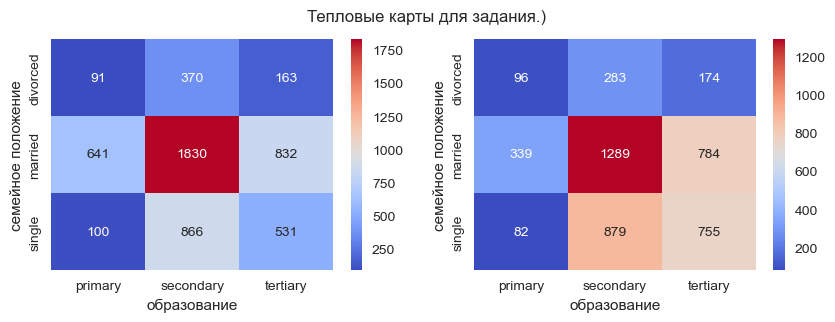

In [31]:
df_for_this_cell = chapter_2_df.groupby(['marital', 'education'])['deposit'].count().reset_index()
print(f"Самыми многочисленными является пересечение категорий: {df_for_this_cell[df_for_this_cell['deposit'] == df_for_this_cell['deposit'].max()].drop('deposit', axis=1).values[0]}")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))

plt.suptitle('Тепловые карты для задания.)')

for i in range(len(chapter_2_df['deposit'].value_counts())):
    
    temp_df = chapter_2_df[chapter_2_df['deposit'] == i]
    
    pivot_s2_p11 = temp_df.pivot_table(values='deposit',
                                       index='marital',
                                       columns='education',
                                       aggfunc='count')
    
    sns.heatmap(pivot_s2_p11, annot=True, fmt='.0f', cmap='coolwarm', ax=ax[i])
    ax[i].set_xlabel('образование')
    ax[i].set_ylabel('семейное положение')

[to contents](#contents)

<h3 id='final_bonus'>Clustergram</h3>
Для себя оставлю такую картиночку. Нравится.)

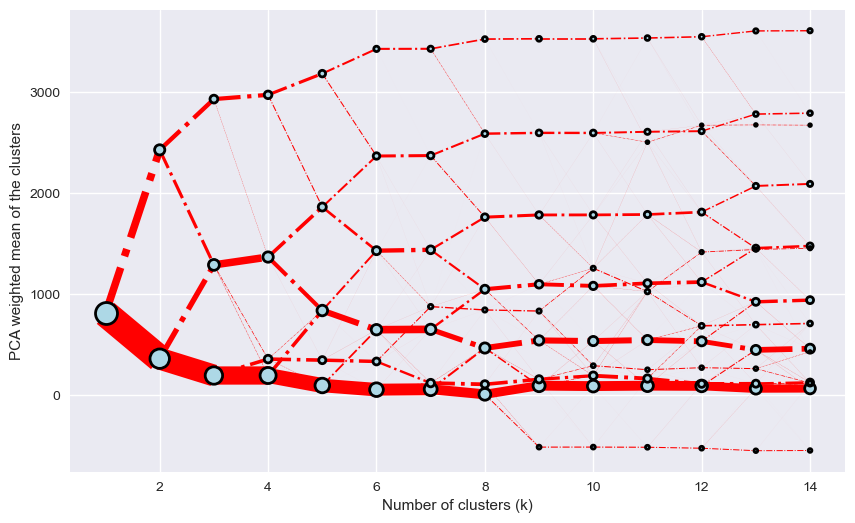

In [55]:
# задаём количество кластеров, для которых хотим получить визуализацию, определяем метод кластеризации.
# verbose=False отвечает за то, чтобы не выводилась лишняя инфа.
cgram = Clustergram(k_range=range(1, 15), method='kmeans', n_init=10, verbose=False)

# запускаем алгоритм.
cgram.fit(chapter_2_df.select_dtypes(include="number"))
cgram.plot(size=0.5,
           linewidth=0.5,
           cluster_style={"color": "lightblue", "edgecolor": "black"},
           line_style={"color": "red", "linestyle": "-."},
           figsize=(10, 6));

---

[to contents](#contents)

<h2><center>Часть 3: Отбор и преобразование признаков.</center></h2>

<h3 id='sometransformationchapter3'>Начальные преобразования части 3</h3>

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

* Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
* Надо отобрать признаки, которые мы будем использовать для обучения модели.

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: `education`.<br>
То же самое необходимо сделать с категориальным признаком `age_category`.

Обработайте его с помощью метода `LabelEncoder`, используя метод без дополнительных настроек. 

In [32]:
chapter_3_df = chapter_2_df.copy()

chapter_3_df['education'] = pd.Series(LabelEncoder().fit_transform(chapter_2_df['education']))
chapter_3_df['age_category'] = pd.Series(LabelEncoder().fit_transform(chapter_2_df['age_category']))

[to contents](#contents)

<h3 id='ex_3_1'>Задание 3.1, 3.2, 3.3</h3>

1. Найдите сумму получившихся значений для признака `education`;
2. Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной `deposit`. Ответ округлите до трёх знаков после точки-разделителя;
3. Вычислите среднее арифметическое для каждой из получившихся переменных (`'default'`, `'housing'`, `'loan'`), сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя. (тут надо было преобразовать `yes`-`no` в бинарники, но я это сделал во второй части)

In [33]:
print(f"3.1. Сумма получившихся значений для признака education: {chapter_3_df['education'].sum()}")
print(f"3.2. Стандартное отклонение по переменной deposit: {round(chapter_3_df['deposit'].std(), 3)}")
print(f"3.3. Сумма 'минок' по трём переменным: {round(chapter_3_df['default'].mean() + chapter_3_df['housing'].mean() + chapter_3_df['loan'].mean(), 3)}")

3.1. Сумма получившихся значений для признака education: 11995
3.2. Стандартное отклонение по переменной deposit: 0.499
3.3. Сумма 'минок' по трём переменным: 0.635


[to contents](#contents)

<h3 id='ex_3_4'>Задание 3.4</h3>

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

* `'job'`;
* `'marital'`;
* `'contact'`;
* `'month'`;
* `'poutcome'`.

Создайте для них dummy-переменные и добавьте их в набор данных.

Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

In [34]:
to_dummy_list = ['job', 'marital', 'contact', 'month', 'poutcome']
chapter_3_df_dummed = pd.concat([chapter_3_df, pd.get_dummies(chapter_3_df[to_dummy_list]).astype(int)], axis=1)

print(f"В датасете теперь: {chapter_3_df_dummed.drop('deposit', axis=1).shape[1]} признаков")

В датасете теперь: 50 признаков


[to contents](#contents)

<h3 id='ex_3_5'>Задание 3.5 + 3.6</h3>

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

В задании 3.6 спрашивается: есть ли корреляция $>=0.9$?

Мультиколинеарности нет.


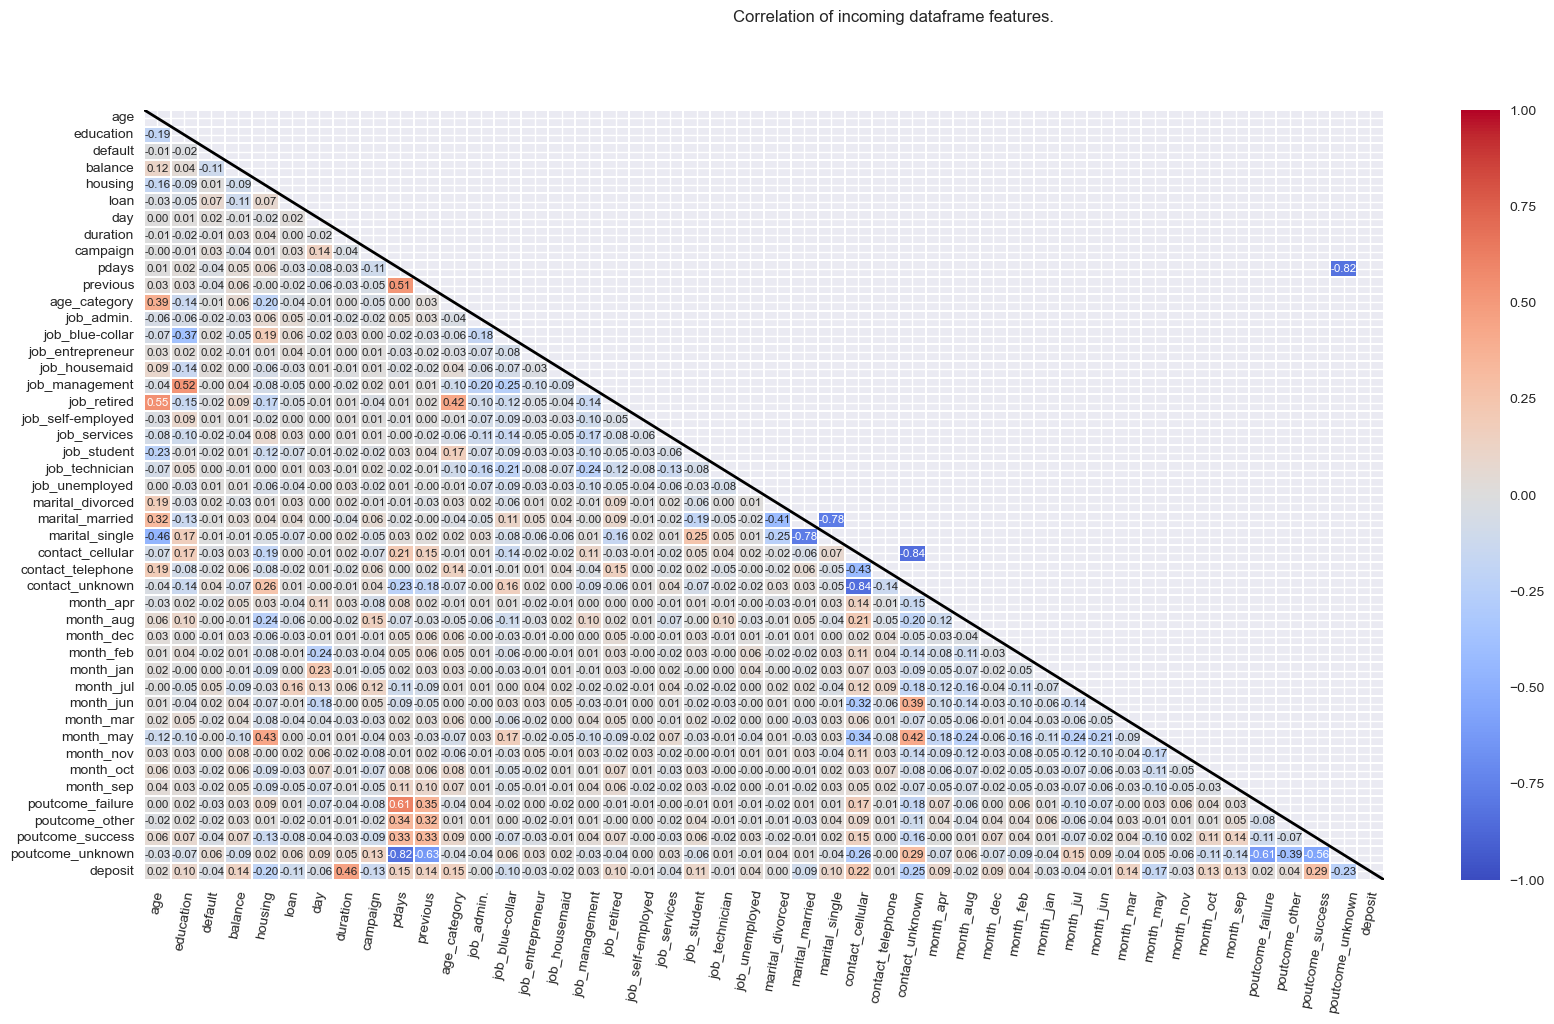

In [39]:
print(f"Мультиколинеарность есть.") if my_corr(chapter_3_df_dummed, corrneg=-0.9, corrpos=0.9, show_high_corr_cols_names=True).shape[0] > 0 else print(f"Мультиколинеарности нет.")

my_corr(chapter_3_df_dummed, targ_col='deposit', corrneg=-0.7, corrpos=0.7, figsize=(20,10), annot_kws={'size': 'small'}, xtickrot=80).show()

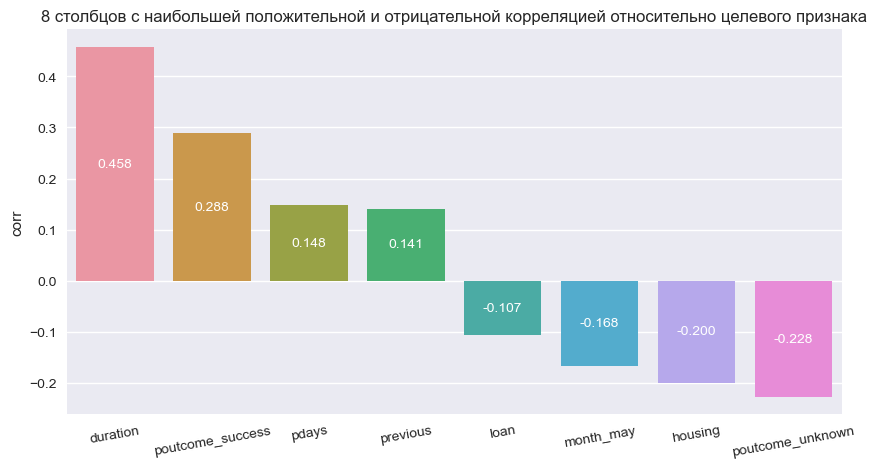

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

corr_df_for_this_cell = my_corr(chapter_3_df_dummed, show_high_corr_cols_names=True)
df_for_this_plot = pd.concat([corr_df_for_this_cell[corr_df_for_this_cell['level_0'] == 'deposit'].head(4), corr_df_for_this_cell[corr_df_for_this_cell['level_0'] == 'deposit'].tail(4)])

sns.barplot(df_for_this_plot, x='level_1', y='corr', ax=ax)
ax.bar_label(ax.containers[0], fmt='%.3f', label_type='center', color='white')
ax.set_title('8 столбцов c наибольшей положительной и отрицательной корреляцией относительно целевого признака')
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.set_xlabel('');

[to contents](#contents)

<h3 id='ex_3_7'>Задание 3.7 + 3.8</h3>

Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр `random_state = 42`, а `размер тестовой выборки` возьмите за 0.33. Не забудьте добавить аргумент, определяющий `сохранение соотношений` целевого признака.

7. Каким получился размер тестовой выборки?
8. Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [36]:
X = chapter_3_df_dummed.select_dtypes(include='number').drop('deposit', axis=1)
y = chapter_3_df_dummed['deposit']

# стратифай можно и не добавлять на самом деле
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

print('3.7. Размеры выборок:')
display(pd.DataFrame([list(X_train.shape), list(X_test.shape), list(y_train.shape), list(y_test.shape)],
                     index=['X_train', 'X_test', 'y_train', 'y_test'],
                     columns=['num_of_rows', 'num_of_cols']).fillna(1).T)

print(f"3.8. Среднее значение целевой переменной на тестовой выборке: {y_test.mean().round(2)}")

print('-------------\nПроверка равноценности выборок:')
display(pd.DataFrame([y_train.value_counts(normalize=True), 
                      y_test.value_counts(normalize=True), 
                      y.value_counts(normalize=True)], 
                     index=['y_train', 'y_test', 'y']))

3.7. Размеры выборок:


,X_train,X_test,y_train,y_test
num_of_rows,6770.0,3335.0,6770.0,3335.0
num_of_cols,45.0,45.0,1.0,1.0


3.8. Среднее значение целевой переменной на тестовой выборке: 0.46
-------------
Проверка равноценности выборок:


deposit,0,1
y_train,0.536780,0.463220
y_test,0.536732,0.463268
y,0.536764,0.463236


[to contents](#contents)

<h3 id='ex_3_9'>Задание 3.9</h3>

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью `SelectKBest` отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр `score_func = f_classif`.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

Укажите одну переменную, не попавшую в данный перечень: `['month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan']`

In [37]:
selector_k_best = SelectKBest(score_func=f_classif, k=15)

X_train_k_best = pd.DataFrame(selector_k_best.fit_transform(X_train, y_train), columns=selector_k_best.get_feature_names_out())
X_test_k_best = X_test[selector_k_best.get_feature_names_out()]

answer_3_9_list = ['month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan']

print(f"Переменная, которая не входит в указанный перечень: {list(filter(lambda x: x not in X_train_k_best.columns[X_train_k_best.columns.str.startswith('month')].to_list(), answer_3_9_list))[0]}")

Переменная, которая не входит в указанный перечень: month_jan


[to contents](#contents)

<h3 id='ex_3_10'>Задание 3.10</h3>

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать `min-max`-нормализацию.

Помните, что нормализация требуется для предикторов, а не для целевой переменной.

Нормализуйте предикторы в обучающей и тестовой выборках.

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [38]:
min_max_scaler_3_10 = preprocessing.MinMaxScaler()
min_max_scaler_3_10.fit(X_train_k_best)

X_train_k_best_norm = min_max_scaler_3_10.transform(X_train_k_best)
X_test_k_best_norm = min_max_scaler_3_10.transform(X_test_k_best)

print(f"Среднее арифметическое для первого предиктора из тестовой выборки: {pd.DataFrame(X_test_k_best_norm).iloc[:, 0].mean().round(2)}")

Среднее арифметическое для первого предиктора из тестовой выборки: 0.47


---

[to contents](#contents)

<h3><center>Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья.</center></h3>

<h3 id='ex_4_1'>Задание 4.1</h3>

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию.<br>
* В качестве алгоритма оптимизации будем использовать `'sag'`, 
* в качестве значения параметра `random_state` возьмём число 42 
* и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

Для получившейся модели вычислите значение `accuracy` на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [39]:
lgr_4_1 = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42, n_jobs=-1)
lgr_4_1.fit(X_train_k_best_norm, y_train)

print(metrics.classification_report(y_test, lgr_4_1.predict(X_test_k_best_norm)))

print('Ответ, принимаемый платформой: 0.81\nВ пачке сказали, что это из-за разных версий библиотек.')

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

Ответ, принимаемый платформой: 0.81
В пачке сказали, что это из-за разных версий библиотек.


[to contents](#contents)

<h3 id='ex_4_2'>Задание 4.2</h3>

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

* criterion = 'entropy';
* random_state = 42.

Остальные параметры оставьте по умолчанию.

Что можно наблюдать после реализации алгоритма и оценки его качества?

In [40]:
dtc_4_2 = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc_4_2.fit(X_train_k_best_norm, y_train)

display(print_metrics(y_train=y_train, y_test=y_test,
                      y_train_pred=[dtc_4_2.predict(X_train_k_best_norm)],
                      y_test_pred=[dtc_4_2.predict(X_test_k_best_norm)],
                      list_of_metrics=['accuracy_score', 'f1_score']))
print('Можно наблюдать переобучение модели.')

,train,test
accuracy_0,1.0,0.747226
f1_0,1.0,0.721874


Можно наблюдать переобучение модели.


[to contents](#contents)

<h3 id='ex_4_3'>Задание 4.3, 4.4</h3>

Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики `accuracy`, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

3. Какое наибольшее значение `accuracy` у вас получилось? Ответ округлите до двух знаков после точки-разделителя.
4. Какую максимальную глубину дерева вы задали?

In [52]:
dtc_4_3 = tree.DecisionTreeClassifier(max_depth=6, random_state=42)
dtc_4_3.fit(X_train_k_best_norm, y_train)

df_for_this_cell = print_metrics(y_train=y_train, y_test=y_test,
                                 y_train_pred=[dtc_4_3.predict(X_train_k_best_norm)],
                                 y_test_pred=[dtc_4_3.predict(X_test_k_best_norm)],
                                 list_of_metrics=['accuracy_score', 'f1_score']).round(2)
display(df_for_this_cell)
print(f"4.3. Наибольшее значение accuracy: {df_for_this_cell.loc['accuracy_0', 'test']}")
print(f"4.4. Максимальная глубина: {dtc_4_3.get_params()['max_depth']}")

,train,test
accuracy_0,0.82,0.81
f1_0,0.81,0.79


4.3. Наибольшее значение accuracy: 0.81
4.4. Максимальная глубина: 6


[to contents](#contents)

<h3 id='ex_4_5'>Задание 4.5</h3>

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью `GridSearch`, перебрав следующие параметры:

* 'min_samples_split': [2, 5, 7, 10];
* 'max_depth': [3,5,7].

Оцените метрику $F_{1}$ на тестовой выборке для наилучшей комбинации перебираемых параметров. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [42]:
param_grid_dtc_4_5 = [{'min_samples_split': [2, 5, 7, 10],
                       'max_depth': [3, 5, 7]}]

gs_4_5 = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42),
                      param_grid=param_grid_dtc_4_5,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)
gs_4_5.fit(X_train_k_best_norm, y_train)

df_for_this_cell = print_metrics(y_train=y_train, y_test=y_test,
                                 y_train_pred=[gs_4_5.predict(X_train_k_best_norm)],
                                 y_test_pred=[gs_4_5.predict(X_test_k_best_norm)],
                                 list_of_metrics=['f1_score']).round(2)

print(f"Наилучшие значения гиперпараметров: {gs_4_5.best_params_}")
print(f"Метрика F1 для наилучшей комбинации: {df_for_this_cell.loc['f1_0', 'test']}")
print('-----------\nПлатформа принимает значение: 0.79')

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}
Метрика F1 для наилучшей комбинации: 0.8
-----------
Платформа принимает значение: 0.79


---

[to contents](#contents)

<h3><center>Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза.</center></h3>

✍ Вы уже смогли обучить несложные модели, и теперь пришло время усложнить их, а также посмотреть, улучшится ли результат (если да, то насколько). Вы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес.

<h3 id='ex_5_1'>Задание 5.1</h3>

Обучите случайный лес со следующими параметрами:

* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

In [46]:
rf_5_1 = ensemble.RandomForestClassifier(n_estimators=100,
                                         criterion='gini',
                                         min_samples_leaf=5,
                                         max_depth=10,
                                         random_state=42,
                                         n_jobs=-1)
rf_5_1.fit(X_train_k_best_norm, y_train)

print(metrics.classification_report(y_test, rf_5_1.predict(X_test_k_best_norm)))
print('------\nПлатформа приняла значения:\naccuracy: 0.83\nrecall: 0.84')

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

------
Платформа приняла значения:
accuracy: 0.83
recall: 0.84


[to contents](#contents)

<h3 id='ex_5_2'>Задание 5.2, 5.3</h3>

Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью `градиентного бустинга`. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

* learning_rate = 0.05;
* n_estimators = 300;
* min_samples_leaf = 5;
* max_depth = 5;
* random_state = 42.

Вопросы:

2. Для построенной модели оцените метрику $F_{1}$ на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
3. Какая модель даёт более качественный прогноз (если посмотреть известные вам метрики в целом)?

In [47]:
gbc_5_2 = ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                              n_estimators=300,
                                              min_samples_leaf=5,
                                              max_depth=5,
                                              random_state=42)
gbc_5_2.fit(X_train_k_best_norm, y_train)

print(metrics.classification_report(y_test, gbc_5_2.predict(X_test_k_best_norm)))
print('5.2. Ответ, принимаемый платформой F1: 0.82')
print('5.3. Платформа приняла ответ "Случайный лес", но в моём случае метрики градиентного бустинга выше, чем у случайного леса.')

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

5.2. Ответ, принимаемый платформой F1: 0.82
5.3. Платформа приняла ответ "Случайный лес", но в моём случае метрики градиентного бустинга выше, чем у случайного леса.


[to contents](#contents)

<h3 id='ex_5_4'>Задание 5.4</h3>

Вы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

В этом задании вам необходимо использовать `стекинг`, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

Для построенной модели оцените метрику `precision` на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [48]:
estimators_5_4 = [('lr', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42, n_jobs=-1)),
                  ('dtc', tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10, random_state=42)),
                  ('gbc', ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                                              n_estimators=300,
                                                              min_samples_leaf=5,
                                                              max_depth=5,
                                                              random_state=42))]

stacking_5_4 = ensemble.StackingClassifier(estimators=estimators_5_4,
                                           final_estimator=linear_model.LogisticRegression(random_state=42, n_jobs=-1))

stacking_5_4.fit(X_train_k_best_norm, y_train)

print(metrics.classification_report(y_test, stacking_5_4.predict(X_test_k_best_norm)))
print('----------\nОтвет, принимаемый платформой precision: 0.82')

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

----------
Ответ, принимаемый платформой precision: 0.82


[to contents](#contents)

<h3 id='ex_5_5'>Задание 5.5</h3>

Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

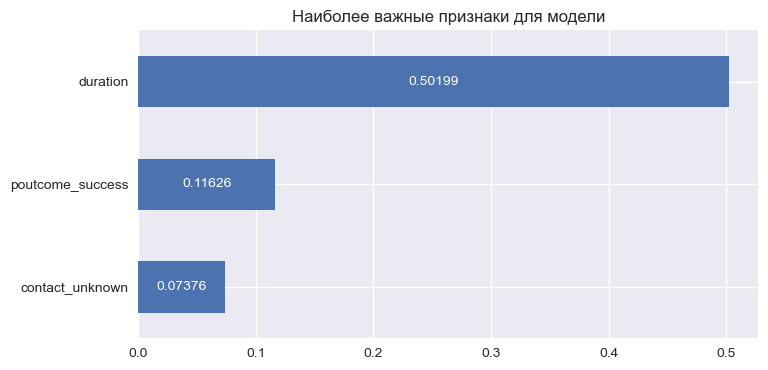

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.DataFrame(gbc_5_2.feature_importances_, index=X_train_k_best.columns).sort_values(by=0).tail(3).plot(kind='barh', legend=False, ax=ax)
ax.bar_label(ax.containers[0], fmt='%.5f', label_type='center', color='white')
ax.set_title('Наиболее важные признаки для модели');

[to contents](#contents)

<h3 id='ex_5_6'>Задание 5.6, 5.7, 5.8</h3>

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи `GridSearch`. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк `Optuna`. Примените его для оптимизации гиперпараметров. Для перебора возьмите `случайный лес` и следующие параметры:

* n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
* max_depth = trial.suggest_int('max_depth', 10, 30, 1);
* min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

Вопросы:

6. Введите значение метрики $F_{1}$ на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.
7. Введите значение метрики `accuracy` на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.
8. Улучшился ли результат по сравнению с предыдущими моделями?

In [50]:
def optuna_rf(trial, X, y, param_dict, cross_val=False, cv=5, random_state=42):
    
    # задаем пространства поиска гиперпараметров
    func_params_dict = {}
    
    for i, j in param_dict.items():
        if 'low' in j:
            func_params_dict[i] = trial.suggest_int(**param_dict[i])
        elif 'choices' in j:
            func_params_dict[i] = trial.suggest_categorical(**param_dict[i])
    
    # создаем модель
    model = ensemble.RandomForestClassifier(**func_params_dict, n_jobs=-1, random_state=random_state)
    
    if not cross_val:
        # обучаем модель
        model.fit(X, y)
        score = f1_score(y, model.predict(X))
    else:
        # проводим кросс-валидацию  
        score = cross_val_score(estimator=model, X=X, y=y, 
                                scoring='f1', cv=cv, n_jobs=-1).mean()

    return score

In [51]:
param_dict_5_6 = {'n_estimators': {'name': 'n_estimators', 'low': 100, 'high': 200, 'step': 1},
                  'max_depth': {'name': 'max_depth', 'low': 10, 'high': 30, 'step': 1},
                  'min_samples_leaf': {'name': 'min_samples_leaf', 'low': 2, 'high': 10, 'step': 1}}

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_5_6 = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_5_6.optimize(partial(optuna_rf, 
                           X=X_train_k_best_norm, y=y_train, 
                           param_dict=param_dict_5_6,
                           cross_val=True,
                           cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                           random_state=42), n_trials=50, show_progress_bar=True)

# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров {study_5_6.best_params}")
print(f"f1_score на обучающем наборе: {study_5_6.best_value:.2f}")

model_optuna_5_6 = ensemble.RandomForestClassifier(**study_5_6.best_params,
                                                   random_state=42,
                                                   n_jobs=-1)
model_optuna_5_6.fit(X_train_k_best_norm, y_train)

display(print_metrics(y_test=y_test, y_train=y_train,
                      y_train_pred=[model_optuna_5_6.predict(X_train_k_best_norm)],
                      y_test_pred=[model_optuna_5_6.predict(X_test_k_best_norm)], 
                      list_of_metrics=['accuracy_score', 'f1_score']).round(2))

print('5.6, 5.7. Курс принимает следующие ответы:\nF1: 0.83\naccuracy: 0.84')
print('---------\n5.8. Улучшился ли результат?\nКурс принимает ответ: да, улучшился.\nПо моему коду, в сравнении с тем же градиентным бустингом - ничего не изменилось.')

  0%|          | 0/50 [00:00<?, ?it/s]

Наилучшие значения гиперпараметров {'n_estimators': 165, 'max_depth': 22, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.83


,train,test
accuracy_0,0.90,0.83
f1_0,0.89,0.82


5.6, 5.7. Курс принимает следующие ответы:
F1: 0.83
accuracy: 0.84
---------
5.8. Улучшился ли результат?
Курс принимает ответ: да, улучшился.
По моему коду, в сравнении с тем же градиентным бустингом - ничего не изменилось.


[to contents](#contents)

В качестве финального вывода могу отметить, что:
* можно было бы побольше пошаманить с выбросами, потестировать метрики;
* можно было бы прогнать через модели таблицу целиком, без отбора 15 наиболее сильных признаков;
* так же можно было бы взять признаки, которые больше всего понравились модели и попробовать сделать какие-нибудь группировки, чтобы попытаться выявить более сильные признаки;
* так же можно было бы поделить признаки друг на друга, чтобы, опять же, попытаться выявить более сильные признаки;
* можно было бы расширить сетки поиска параметров моделей;
* о, да, логарифмировать логнормальные признаки (забыл совсем про это)

Но это всё потом, т.к. я сейчас крайне сильно отстаю от графика курса. Потому выполнил проект по-дефолту, чтобы ответить на вопросы курса.

Спасибо за просмотр.